# Movie Box Office Revenue Prediction

#### Project Members:  Bibhas Shrestha, Avash Shrestha and Nickson Bett


### Background

The film industry continues to grow in popularity, with major blockbuster hits releasing every year, some making hundreds of millions or even over a billion dollars in worldwide revenue. While many movies achieve immense success at the box office, there are plenty that fail to meet expectations, both financially and critically. Understanding what makes certain films successful while others flop offers valuable insights, especially when measured by global box office earnings. These earnings not only reflect a movie's financial performance but also provide a glimpse into how much audiences have loved the film. Analyzing box office revenue and a movie’s performance can therefore be fascinating, as it reveals key factors that contribute to a film's success. With this project, we aim to explore the elements behind box office hits, conduct a thorough analysis, and ultimately predict the revenue of movies based on significant factors. Our work includes exploratory data analysis, feature engineering, and predictive modeling, all based on data provided by TMDb (The Movie Database).


### Importing Libraries

In [5]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from statistics import median
from statistics import mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, accuracy_score
from lightgbm import LGBMRegressor

### Loading the Dataset

In [7]:
# Load the training data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

First, we load the data, which has already been split into train and test sets. Although this approach is somewhat unconventional, we decided to keep the provided splits. For our modeling process, we focused solely on the training set, further dividing it into a train and validation set. The test set was reserved for final evaluation.


In [9]:
# Inspection of the data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [10]:
print ('The train data has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print ('---------------------------------------------')
print ('The test data has {} rows and {} columns'.format(test.shape[0],test.shape[1]))

The train data has 3000 rows and 23 columns
---------------------------------------------
The test data has 4398 rows and 22 columns


The test set contains one less column than the training set, as it does not include the 'revenue' column, which is the target variable for our predictions.


In [12]:
train.head(10)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
5,6,NaN,8000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",NaN,tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,...,8/6/87,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Pinocchio and the Emperor of the Night,NaN,"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638
6,7,NaN,14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://www.thepossessionmovie.com/,tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,...,8/30/12,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fear The Demon That Doesn't Fear God,The Possession,NaN,"[{'cast_id': 23, 'character': 'Clyde', 'credit...","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...",85446075
7,8,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,tt0391024,en,Control Room,A chronicle which provides a rare window into ...,1.949044,...,1/15/04,84.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,Different channels. Different truths.,Control Room,"[{'id': 917, 'name': 'journalism'}, {'id': 163...","[{'cast_id': 2, 'character': 'Himself', 'credi...","[{'credit_id': '52fe47a69251416c750a0daf', 'de...",2586511
8,9,"[{'id': 256377, 'name': 'The Muppet Collection...",0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,tt0117110,en,Muppet Treasure Island,After telling the story of Flint's last journe...,6.902423,...,2/16/96,100.0,"[{'

In [13]:
print("Missing values in the training set:\n", train.isna().sum())
print("\nMissing values in the test set:\n", test.isna().sum())

Missing values in the training set:
 id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

Missing values in the test set:
 id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title  

### Exploratory Data Analysis and Feature Engineering


There are a total of 23 variables in this dataset (including the revenue), which are considered below. We will explore variables and perform univariate and bivariate analysis (to revenue) where necessary. In tandem with data exploration, we will begin doing feature engineering to create features for our models that are better representative of the data or in an easier format to work with.

In [16]:
train_features = []
log_features = []
cols_to_drop = []

Before beginning the analysis, we create three lists: 1. features to be used, 2. features that will undergo log transformation, and 3. columns to be dropped. As we analyze each variable, we will update these lists, allowing for a more efficient selection of relevant columns for modeling.


### Revenue
The revenue variable is our target label, so it will be analyzed first. This column reflects the worldwide box office earnings of each film.


### Univariate Analysis

In [20]:
print('Number of movies with missing revenue:', train.revenue.isna().sum())


Number of movies with missing revenue: 0


In [21]:
print("Average revenue: %.2f" % train.revenue.mean())
print("Middle value of revenue: %.2f" % train.revenue.median())


Average revenue: 66725851.89
Middle value of revenue: 16807068.00


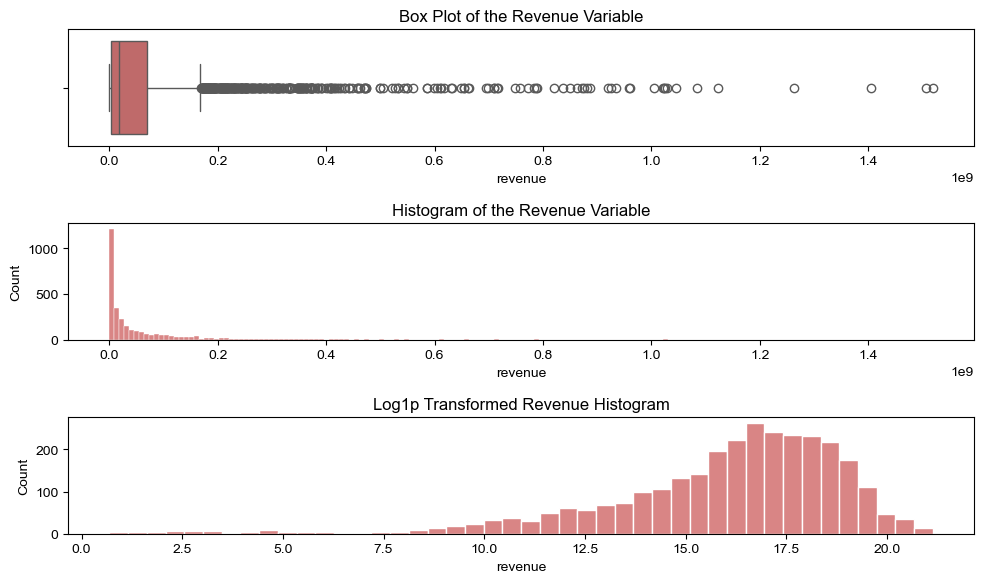

In [22]:
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.revenue, ax=ax[0], color='indianred')
ax[0].set_title("Box Plot of the Revenue Variable")
sns.histplot(train.revenue, kde=False, ax=ax[1], color='indianred')
ax[1].set_title("Histogram of the Revenue Variable")
sns.histplot(np.log1p(train.revenue), kde=False, ax=ax[2], color='indianred')
ax[2].set_title("Log1p Transformed Revenue Histogram")

f.tight_layout()

# Retrieving and printing the 20 smallest revenue values in the dataset
smallest_revenues = train.revenue.nsmallest(20)
print(smallest_revenues)

It is evident that there are several extremely low and unrealistic values in the revenue column. This is an issue we may need to address later, and we will revisit it after inspecting the rest of the dataset.


In [25]:
# Adding the 'revenue' column to the list of features to be log-transformed
log_features.append("revenue")

When examining the target variable, we notice that the revenue distribution is heavily skewed to the right. This is expected, as the average movie earns close to $67 million, but a significant number of films make hundreds of millions, especially major box office hits. These high-grossing releases skew the revenue data considerably. Applying a log transformation makes the distribution much more manageable and helps reduce this skew.


### Belongs to Collection
This column indicates whether a film is part of a collection, meaning it belongs to a series of movies rather than being a standalone film. If a movie is part of a collection, the column contains the collection name as a string; otherwise, it is marked as NA. To simplify our analysis, we will modify this column to represent 1 if a movie is in a collection and 0 if it is not.

In [28]:
# Converting the 'belongs_to_collection' column to binary:
# 1 if the movie belongs to a collection (i.e., the value is a string),
# 0 if it does not (i.e., the value is NA).
train.belongs_to_collection = train.belongs_to_collection.apply(lambda x: 1 if type(x) == str else 0)
test.belongs_to_collection = test.belongs_to_collection.apply(lambda x: 1 if type(x) == str else 0)


In [29]:
# Printing the count of movies that belong to a collection (1) versus those that do not (0)
print(train.belongs_to_collection.value_counts())


belongs_to_collection
0    2396
1     604
Name: count, dtype: int64


The majority of movies are standalone, which is expected, even though there are many well-known film series. Most films are not part of a collection.


### Univariate Analysis

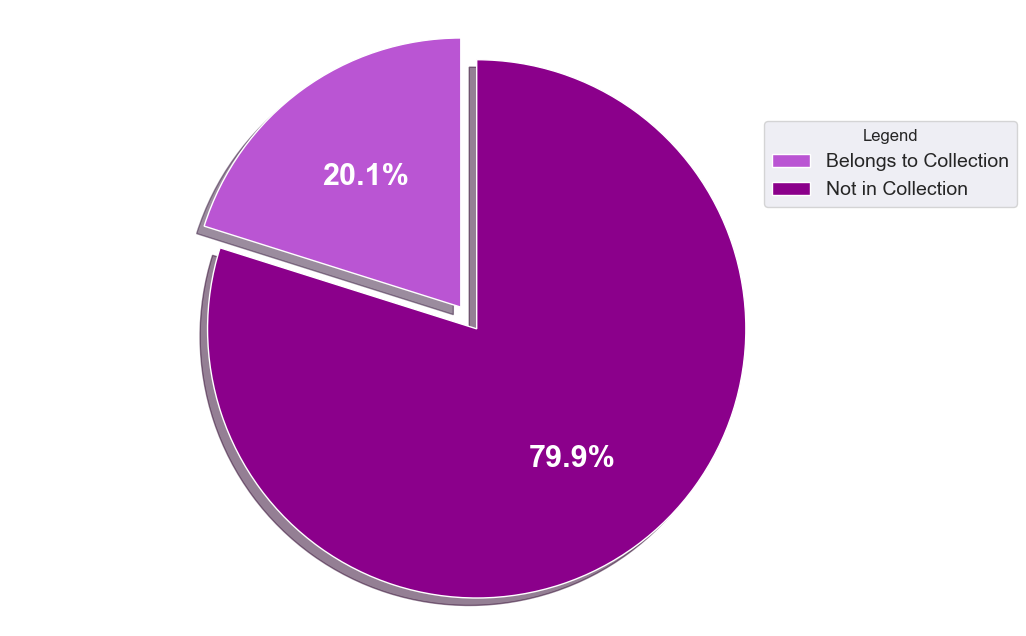

In [32]:
# Plotting data for movies that belong to a collection vs. standalone movies
labels = 'Belongs to Collection', 'Not in Collection'  # Labels for the pie chart
btc_1 = [sum(train.belongs_to_collection), (train.belongs_to_collection == 0).sum(axis=0)]  # Data for the pie chart
explode = (0.1, 0)  # Emphasize the first slice for movies part of a collection

colors = ['mediumorchid', 'darkmagenta']  # Colors for the slices

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, 
       colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})  # Adding text style and format
ax.axis('equal')  # Ensures the chart is a perfect circle

# Adding a legend to the pie chart
ax.legend(labels,
          title="Legend",
          loc="center left",  # Position of the legend
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))  # Bounding box for the legend


Out of 3,000 data points, 604 movies (20.1%) were part of a film collection, while the remaining 2,396 movies (79.9%) were standalone. Being part of a collection could be a significant factor in predicting revenue, as audiences might be more inclined to pay for the next installment in a series they are already invested in. The concept of serialized media dates back to 1836 with Charles Dickens' *The Pickwick Papers*, and it has grown in popularity ever since, continuing strongly into the 21st century. Given the enduring appeal of serial storytelling, it is hypothesized that movies belonging to a collection will show a positive correlation with higher revenue.


In [34]:
train.isna().sum()

id                          0
belongs_to_collection       0
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

### Bivariate Analysis

belongs_to_collection
0    2396
1     604
Name: count, dtype: int64


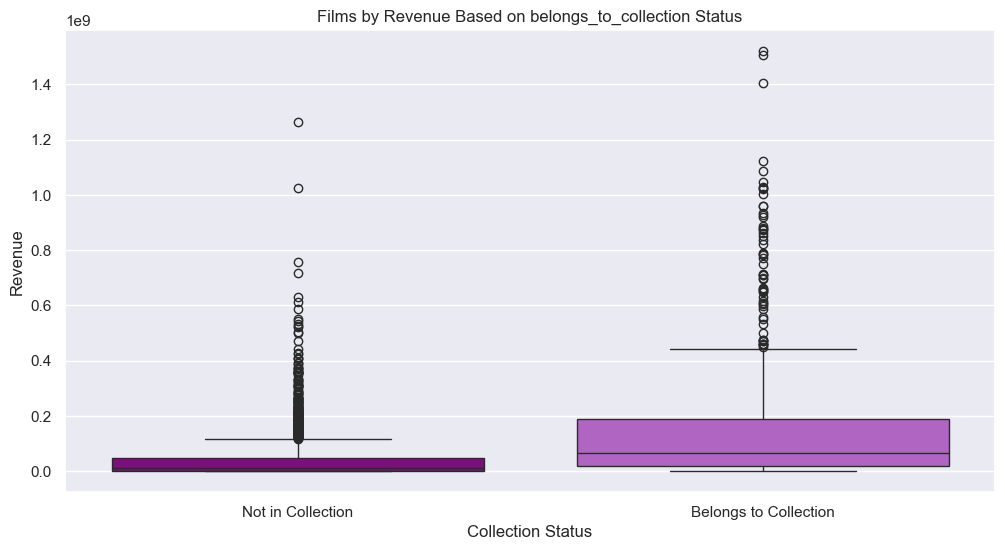

In [36]:
# Bivariate analysis of revenue with belongs_to_collection
print(train['belongs_to_collection'].value_counts())

# Labels for the x-axis categories
labels = 'Not in Collection', 'Belongs to Collection'

# Custom color palette for the boxplot
pal1 = ['darkmagenta', 'mediumorchid']

# Creating a boxplot to compare revenue based on collection status
fig, ax = plt.subplots(figsize=(12, 6))  # Setting the figure size
sns.boxplot(x='belongs_to_collection', y='revenue', data=train, hue='belongs_to_collection', palette=pal1, legend=False)  # Using hue and removing legend

plt.title('Films by Revenue Based on belongs_to_collection Status')  # Title of the plot
plt.ylabel("Revenue")  # Label for the y-axis
plt.xlabel("Collection Status")  # Label for the x-axis

# Setting custom x-axis tick labels to show 'Not in Collection' and 'Belongs to Collection'
ax.set_xticks([0, 1])
ax.set_xticklabels(labels)

plt.show()


The graph above supports the hypothesis that being part of a collection positively correlates with higher film revenue. Further analysis could be conducted to quantify the exact benefit of a film's 'Belongs in Collection' status.


In [38]:
train_features.append('belongs_to_collection')

In [39]:
# Importing Pearson correlation function
from scipy.stats import pearsonr

# Analyzing correlation between belongs_to_collection and revenue
corr, _ = pearsonr(train['belongs_to_collection'], train['revenue'])
print('Pearson\'s correlation between belongs_to_collection and revenue: %.3f' % corr)

# Analyzing correlation between belongs_to_collection and log-transformed revenue
corr, _ = pearsonr(train['belongs_to_collection'], np.log1p(train['revenue']))
print('Pearson\'s correlation between belongs_to_collection and the log-transformed revenue: %.3f' % corr)


Pearson's correlation between belongs_to_collection and revenue: 0.339
Pearson's correlation between belongs_to_collection and the log-transformed revenue: 0.257


As hypothesized, there is a small positive correlation between a film belonging to a collection and its revenue.


### Budget
The budget column represents the estimated income and expenditure for a film. Intuitively, this seems like an important variable for predicting revenue, as higher-budget films often have higher production values and are expected to achieve greater success. However, this is not always the case, and it warrants further investigation.


### Univariate Analysis

In [43]:
# Printing the number of movies with missing budget values
print('Movies missing a budget:', train.budget.isna().sum())

Movies missing a budget: 0


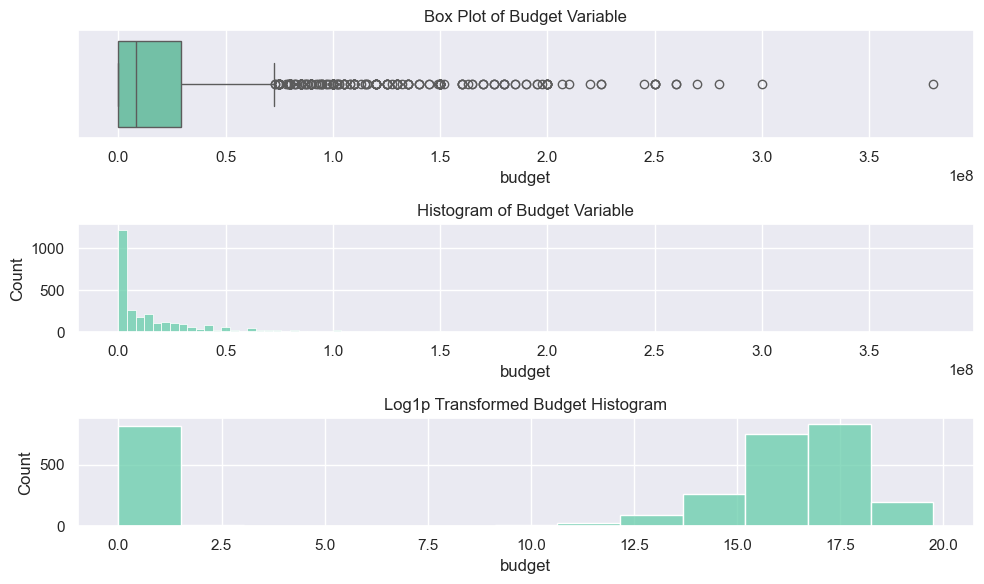

In [44]:
# Plotting the budget data
f, ax = plt.subplots(3, figsize=(10,6))  # Creating subplots for the three visualizations

sns.set(rc={'figure.figsize':(12,8)})  # Setting figure size for Seaborn plots

# Box plot for the budget variable
sns.boxplot(x=train.budget, ax=ax[0], color='mediumaquamarine')
ax[0].set_title("Box Plot of Budget Variable")

# Histogram of the budget variable
sns.histplot(train.budget, kde=False, ax=ax[1], color='mediumaquamarine')
ax[1].set_title("Histogram of Budget Variable")

# Log1p transformed histogram for the budget variable
sns.histplot(np.log1p(train.budget), kde=False, ax=ax[2], color='mediumaquamarine')
ax[2].set_title("Log1p Transformed Budget Histogram")

# Adjusting layout for better visualization
f.tight_layout()


In [45]:
# Printing the number of movies with a budget listed as 0
print('Movies with budget listed as 0: ', (train.budget == 0).sum())


Movies with budget listed as 0:  812


The distribution of the budget in the training set is also heavily skewed to the right, much like the revenue. Therefore, we examine the log-transformed distribution as well. While no movies are missing a budget, there are over 800 movies in the training set with a budget listed as 0. This is highly unlikely, as all produced films have some form of budget. It's probable that these 0 values were used as placeholders when the actual budget data was unavailable. To clean the data, we will replace these 0 values with the median budget to help reduce the skew.


In [47]:
# Calculating the median budget for movies that have a budget greater than 0
median = train.loc[train['budget'] > 0, 'budget'].median()

# Replacing budget values of 0 with the median budget in the training set
train["budget_processed"] = train["budget"].mask(train["budget"] == 0, median)

# Replacing budget values of 0 with the median budget in the test set
test["budget_processed"] = test["budget"].mask(test["budget"] == 0, median)

In [48]:
# Retrieving the 10 smallest values from the 'budget_processed' column in the training set
train.nsmallest(10, 'budget_processed')['budget_processed']

334     1
695     1
849     1
1346    1
2255    1
1754    2
2032    4
1198    5
1800    5
639     6
Name: budget_processed, dtype: int64

There appear to be several unrealistic budget values beyond just those listed as 0. To address this, we will replace all budget values below 10,000 USD, as this seems to be a reasonable minimum threshold. No major feature film is realistically produced for under 10,000 USD. Even one of the most famous examples of a low-budget success, *The Blair Witch Project*, had a budget of 40,000 USD.


In [50]:
median = train.loc[train['budget'] >= 10000, 'budget'].median()
train["budget_processed"] = train["budget"].mask(train["budget"] < 10000, median)
test["budget_processed"] = test["budget"].mask(test["budget"] < 10000, median)

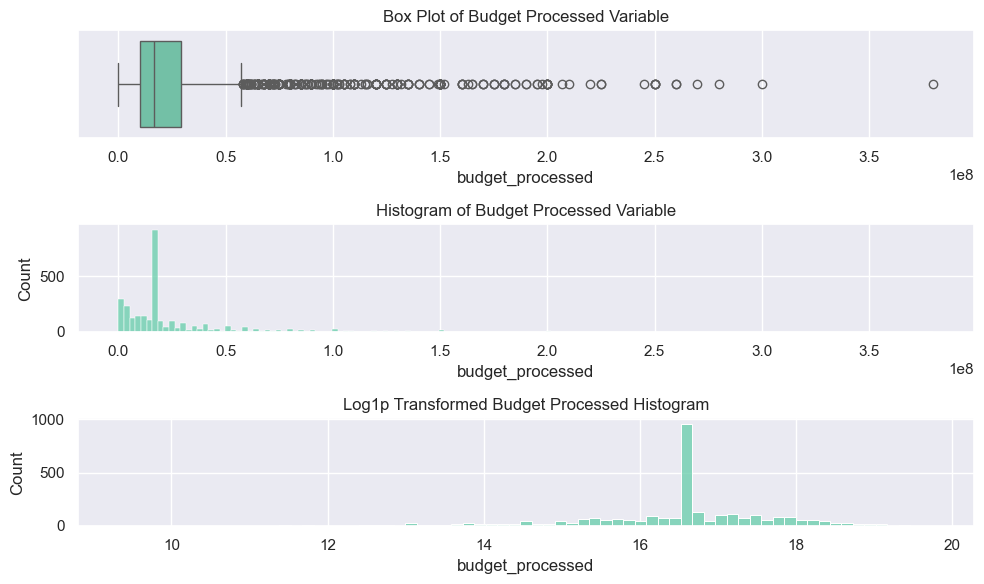

In [51]:
# Plotting the processed budget data
f, ax = plt.subplots(3, figsize=(10,6))  # Creating subplots for different visualizations

sns.set(rc={'figure.figsize':(12,8)})  # Setting figure size for Seaborn plots

# Box plot for the processed budget variable
sns.boxplot(x=train.budget_processed, ax=ax[0], color='mediumaquamarine')
ax[0].set_title("Box Plot of Budget Processed Variable")

# Histogram of the processed budget variable
sns.histplot(train.budget_processed, kde=False, ax=ax[1], color='mediumaquamarine')
ax[1].set_title("Histogram of Budget Processed Variable")

# Log1p transformed histogram for the processed budget variable
sns.histplot(np.log1p(train.budget_processed), kde=False, ax=ax[2], color='mediumaquamarine')
ax[2].set_title("Log1p Transformed Budget Processed Histogram")

# Adjusting layout for better visualization
f.tight_layout()


Since many values in the budget column were below 10,000, replacing them with the median has created a large cluster of data around this value. This distribution is still not ideal, so we will look for a more suitable method to replace these values in the future.


### Bivariate Analysis

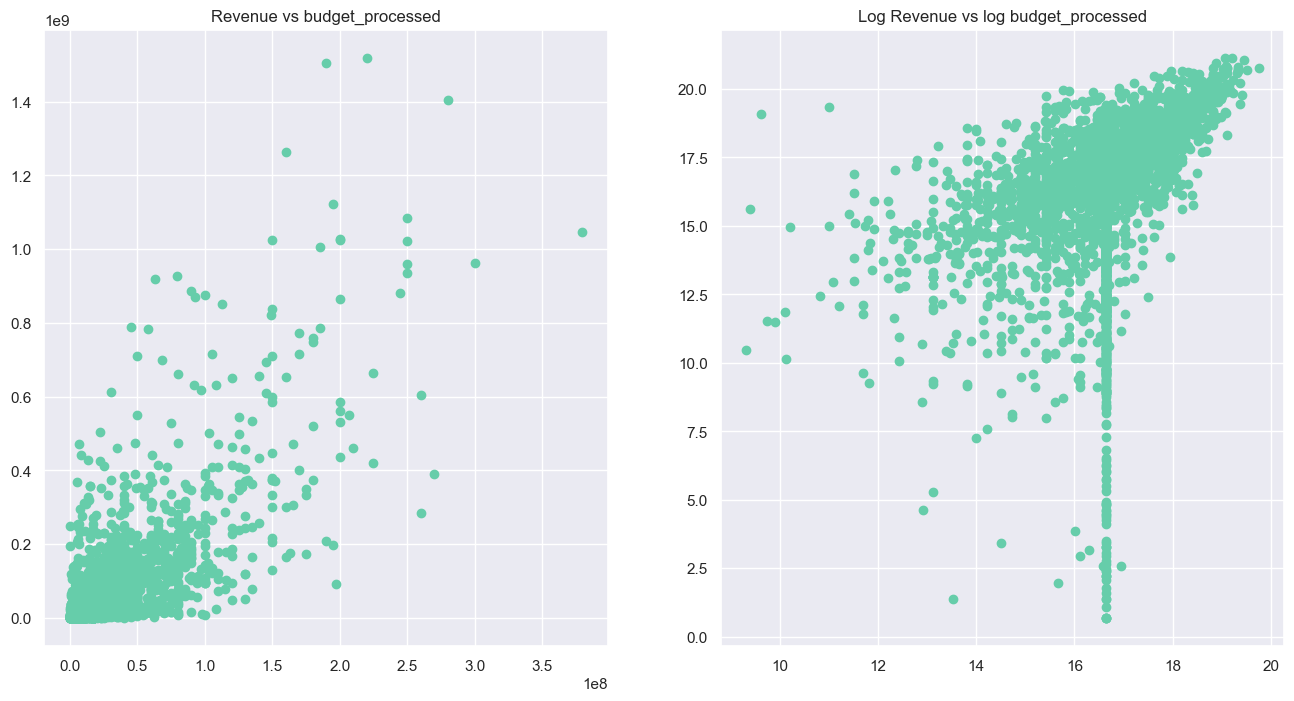

In [54]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget_processed'], train['revenue'], color='mediumaquamarine')
plt.title('Revenue vs budget_processed');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget_processed']), np.log1p(train['revenue']), color='mediumaquamarine')
plt.title('Log Revenue vs log budget_processed');

In [55]:
# Adding 'budget_processed' to the list of features to be log-transformed
log_features.append('budget_processed')

In [56]:
#analysis of correlation and create log feature probably
corr, _ = pearsonr(train['budget_processed'], train['revenue'])
print('Pearsons correlation between budget_processed and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['budget_processed']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed transformed budget_processed and log transformed revenue: %.3f' % corr)

Pearsons correlation between budget_processed and revenue: 0.746
Pearsons correlation between log transformed transformed budget_processed and log transformed revenue: 0.373


The analysis shows a fairly strong correlation between the budget and revenue variables.


### Genres
The genres column represents the genre(s) of a film. Since different genres may perform differently at the box office, this is an interesting variable to explore to determine if there is any relationship to revenue.


In [59]:
train['genres'].head()

0                       [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
3    [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4    [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
Name: genres, dtype: object

In [60]:
# Printing the number of movies with missing genre information
print("Movies missing genres: ", train['genres'].isna().sum())

Movies missing genres:  7


The genres column contains a lot of unnecessary information, making it difficult to work with. To address this, we will preprocess the data by using a regular expression to extract only the genre names and store them in a new column as a list for each film. Additionally, we will fill any missing values (NA) with a blank string.


### Pre-processing

In [63]:
# Filling missing values in the 'genres' column with an empty string
train['genres'] = train['genres'].fillna('')

# Extracting genre names using a regular expression and creating a new column 'genres_reform'
train['genres_reform'] = train['genres'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))

# Applying the same preprocessing to the test dataset
test['genres'] = test['genres'].fillna('')

# Extracting genre names in the test dataset and storing in 'genres_reform'
test['genres_reform'] = test['genres'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))


With the list of genres for each film now available, we will unpack all the genres into a new DataFrame to facilitate easier exploration and analysis. While this study does not delve into it, an intriguing direction for future research could be examining the temporal trends in genre popularity. Different genres may attract varying levels of interest from moviegoers across different historical film periods.


In [65]:
# Function to unpack all of the different genres into unique columns
def unpackCol(genre_list, df):
    for i in range(len(df)):
        for name in genre_list[i]:
            if name not in df.columns:
                df[name] = 0
            df.loc[i, name] = 1  # Use .loc to avoid the chained assignment warning
    return df

In [66]:
# Creating an empty DataFrame and unpacking genres into unique columns from 'genres_reform'
df = pd.DataFrame()
df = unpackCol(train['genres_reform'], train)  # Unpacking genres into separate columns

# Printing the column names to verify the unique genre columns
print(df.columns)

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'budget_processed', 'genres_reform', 'Comedy', 'Drama', 'Family',
       'Romance', 'Thriller', 'Action', 'Animation', 'Adventure', 'Horror',
       'Documentary', 'Music', 'Crime', 'Science Fiction', 'Mystery',
       'Foreign', 'Fantasy', 'War', 'Western', 'History', 'TV Movie'],
      dtype='object')


In [67]:
# Creating a new feature that counts the number of genres for each film
train['num_genres'] = train.genres_reform.apply(lambda x: len(x))
test['num_genres'] = test.genres_reform.apply(lambda x: len(x))

# Displaying the count of films by the number of genres they belong to
train['num_genres'].value_counts()

num_genres
2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: count, dtype: int64

We create a new column that counts the number of genres listed for each movie. This may be interesting to explore further to see if there is any correlation between the number of genres and revenue.


### Univariate Analysis

Text(0.5, 0, 'Genre')

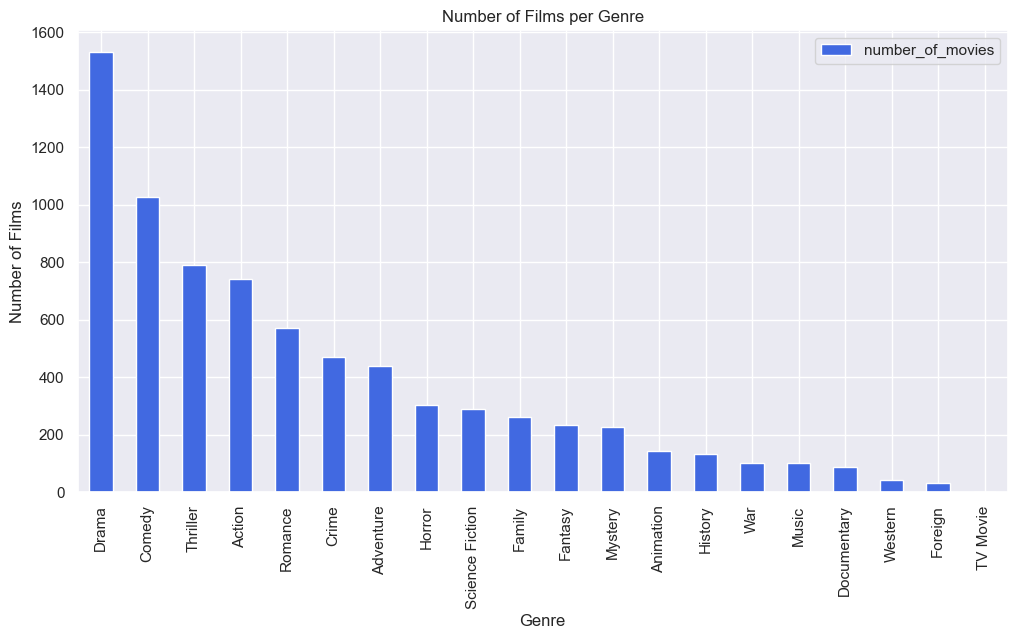

In [70]:
# Creating a dictionary to count the number of instances of each genre
genresDict = dict()

# Iterating through the 'genres_reform' column to count each genre
for genre in df["genres_reform"]:
    for elem in genre:
        if elem not in genresDict:
            genresDict[elem] = 1  # Initialize the genre count if it's not in the dictionary
        else:
            genresDict[elem] += 1  # Increment the count for the genre

# Setting figure size for the plot
sns.set(rc={'figure.figsize':(12,6)})

# Converting the genre dictionary into a DataFrame for easier plotting
genres_df = pd.DataFrame.from_dict(genresDict, orient='index')
genres_df.columns = ["number_of_movies"]  # Renaming the column
genres_df = genres_df.sort_values(by="number_of_movies", ascending=False)  # Sorting genres by the number of movies

# Plotting the number of films per genre as a bar chart
genres_df.plot.bar(color='royalblue')

# Adding plot labels and title
plt.title("Number of Films per Genre")
plt.ylabel("Number of Films")
plt.xlabel("Genre")


Genres of movies often follow specific trends in popularity, such as the recent surge in superhero films that began in the 1990s with 20th Century Fox's *X-Men* series. While superhero movies have existed since at least 1978 with Richard Donner's *Superman*, the latest trend has had a defining impact on the film industry over the past two decades. For the purposes of this report, superhero films are categorized under Action/Adventure (and Fantasy), though these genres also include other popular subgenres.

Action and Adventure films have a relatively high number of releases, leading to the hypothesis that more common genres may also be more popular and thus generate higher revenues. As a result, Drama, Comedy, and Thriller films may be expected to show the highest revenues. However, the role of genre in determining a film's revenue (and predicting future success) is significant, especially given the often unpredictable nature of audience preferences.


In [72]:
# List of film genres by the number of films in each genre, sorted by order of count
genres = [
    'Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Crime', 
    'Adventure', 'Horror', 'Science Fiction', 'Family', 'Fantasy', 
    'Mystery', 'Animation', 'History', 'War', 'Music', 'Documentary', 
    'Western', 'Foreign', 'TV Movie'
]

# Printing the sum of films for each genre
for genre in genres:
    print(f"{genre}: {df[genre].sum()}")

Drama: 1531
Comedy: 1028
Thriller: 789
Action: 741
Romance: 571
Crime: 469
Adventure: 439
Horror: 301
Science Fiction: 290
Family: 260
Fantasy: 232
Mystery: 225
Animation: 141
History: 132
War: 100
Music: 100
Documentary: 87
Western: 43
Foreign: 31
TV Movie: 1


In terms of genres, we observe a nearly logarithmic distribution, with Drama (1531 films) being the most common and TV Movies (1 film) being the least. For the purposes of this analysis, we assume that this dataset is representative of broader trends in filmography. Typically, we might expect more popular genres to correlate with higher revenues due to their widespread appeal. However, it's important to also consider the unique draw of films in "rare genres." For example, *La La Land*, a musical, grossed `$446.1 million` at the box office with a modest `$30 million` budget. Therefore, the potential for outliers or even inverse trends in genre popularity and revenue warrants further exploration.



### Bivariate Analysis

In [75]:
# Bivariate analysis of revenue with genre

# Getting the index values (genre names) from the genres DataFrame
genres_df.index.values

# Creating binary columns for each genre in the df dataset (1 if the movie belongs to that genre, 0 if not)
for g in genres_df.index.values:
    df[g] = df['genres_reform'].apply(lambda x: 1 if g in x else 0)

# Calculating the median revenue per genre type
for i, g in enumerate(genres_df.index.values):
    genres_df.loc[g, "median_rev"] = df[df[g] == 1].revenue.median()  # Median revenue for movies of each genre

# Sorting the genres by number of movies and median revenue, and displaying the top 10
genres_df.sort_values(by=["number_of_movies", "median_rev"], ascending=False).head(10)

# Calculating the mean revenue per genre type
for i, g in enumerate(genres_df.index.values):
    genres_df.loc[g, "mean_rev"] = df[df[g] == 1].revenue.mean()  # Mean revenue for movies of each genre

# Sorting the genres by number of movies and mean revenue, and displaying the top 10
genres_df.sort_values(by=["number_of_movies", "mean_rev"], ascending=False).head(10)

,number_of_movies,median_rev,mean_rev
Drama,1531,11293663.0,4.540607e+07
Comedy,1028,18809184.0,6.087574e+07
Thriller,789,21890845.0,6.833664e+07
Action,741,36000000.0,1.110434e+08
Romance,571,14016568.0,5.270501e+07
Crime,469,24048000.0,5.949128e+07
Adventure,439,59700000.0,1.758095e+08
Horror,301,17037887.0,5.270907e+07
Science Fiction,290,35109301.5,1.223672e+08
Family,260,57470029.5,1.388978e+08


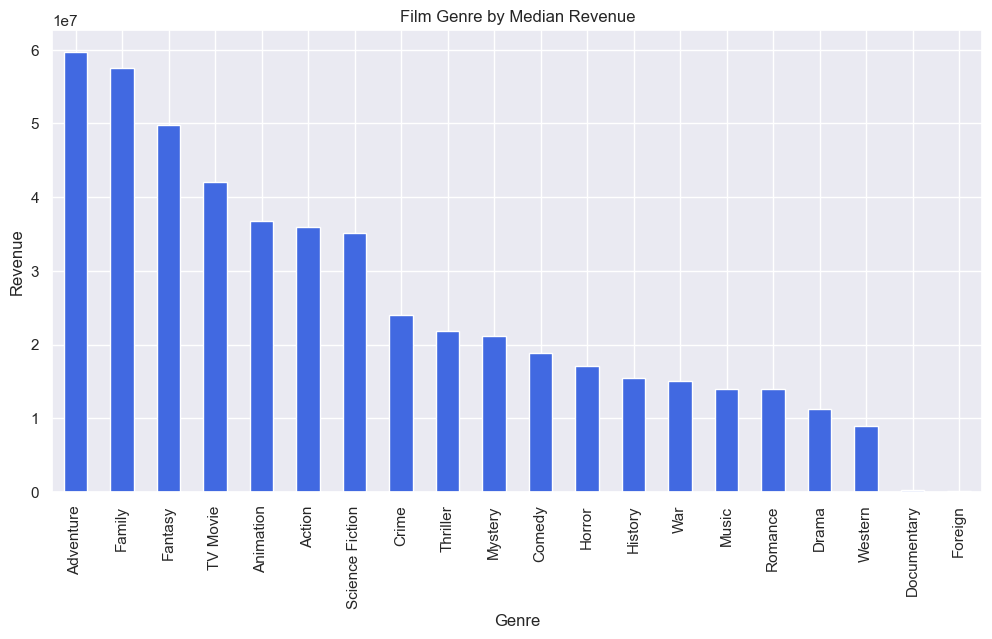

In [76]:
# Plotting genres by median revenue
genres_df.sort_values(by=["median_rev"], ascending=False).median_rev.plot.bar(color='royalblue')

# Adding title and labels to the plot
plt.title("Film Genre by Median Revenue")
plt.ylabel("Revenue")
plt.xlabel("Genre")

# Displaying the plot
plt.show()

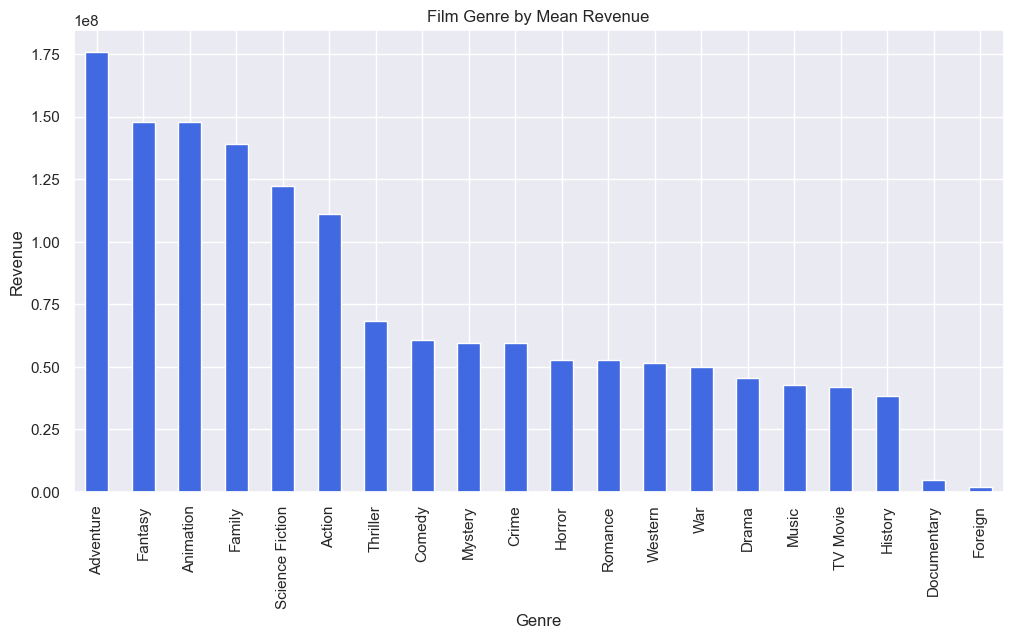

In [77]:
# Plotting genres by mean revenue
genres_df.sort_values(by=["mean_rev"], ascending=False).mean_rev.plot.bar(color='royalblue')

# Adding title and labels to the plot
plt.title("Film Genre by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Genre")

# Displaying the plot
plt.show()

In both the 'Film Genre by Median Revenue' and 'Film Genre by Mean Revenue' plots, Adventure films have the highest revenue values, with the ordering being fairly consistent between the two, except for a few notable changes. For instance, using `median_rev`, the TV Movie genre ranks fourth in terms of revenue, but using `mean_rev` drops it to fourth lowest. Similarly, History drops five places from `median_rev` to `mean_rev`, while Comedy rises by three spots.

Although some common film genres (those with a higher number of films in the training data) perform well in terms of revenue, the initial hypothesis that a genre’s popularity would correlate positively with revenue is disproven by the relatively lower revenues for Dramas, Comedies, and Thrillers—the three most common genres in the dataset. This could be due to saturated demand in these genres or other unrelated factors. What is clear is that Adventure, Family, Fantasy, and Animation genres consistently rank high in both median and mean revenue.


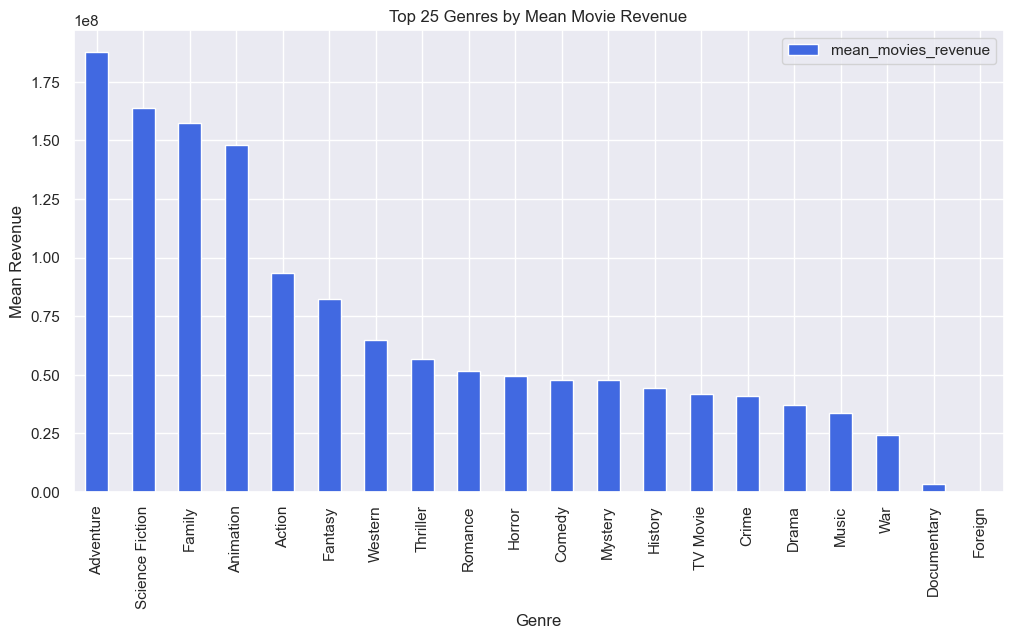

In [79]:
# Creating a dictionary to store total revenue and count for each top genre
topGenreDict = {}

# Iterating through the 'revenue' and 'genres_reform' columns in the train dataset
for element in train[["revenue", "genres_reform"]].values:
    temp = 1  # Set temp to compare results for top genre (1st genre in the list)
    
    # If the movie has fewer genres than 'temp', adjust 'temp' to the length of the genre list
    if len(element[1]) < temp:
        temp = len(element[1])
    
    # Iterating through the top 'temp' genres for each movie
    for i in range(temp):
        if element[1][i] not in topGenreDict:
            # If the genre is not already in the dictionary, add it with revenue and count
            topGenreDict[element[1][i]] = [element[0], 1]
        else:
            # If the genre is already in the dictionary, update the total revenue and count
            topGenreDict[element[1][i]][0] += element[0]
            topGenreDict[element[1][i]][1] += 1

# Calculating the mean revenue for each genre
for genre in topGenreDict:
    topGenreDict[genre][0] = topGenreDict[genre][0] / topGenreDict[genre][1]  # Mean revenue
    topGenreDict[genre] = topGenreDict[genre][0]  # Store only the mean revenue in the dictionary

# Converting the dictionary into a DataFrame for easier manipulation and visualization
genres_df = pd.DataFrame.from_dict(topGenreDict, orient='index', columns=["mean_movies_revenue"])

# Sorting the DataFrame by mean revenue and plotting the top 25 genres as a bar chart
genres_df.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='royalblue')

# Displaying the plot
plt.title("Top 25 Genres by Mean Movie Revenue")
plt.xlabel("Genre")
plt.ylabel("Mean Revenue")
plt.show()

In [80]:
# Sorting the topGenreDict in ascending order of mean revenue
# This allows us to easily access the least successful genres first
topGenreDict = {k: v for k, v in sorted(topGenreDict.items(), key=lambda item: item[1], reverse=False)}

# Sorting the genresDict in descending order of number of films
# This allows us to easily access the most common genres first
genresDict = {k: v for k, v in sorted(genresDict.items(), key=lambda item: item[1], reverse=True)}

# Printing the sorted dictionaries
print("Top Genres by Mean Revenue (Least to Most Successful):")
print(topGenreDict)

print("\nGenres by Number of Films (Most to Least Common):")
print(genresDict)

Top Genres by Mean Revenue (Least to Most Successful):
{'Foreign': 140650.0, 'Documentary': 3538249.971830986, 'War': 24388514.85, 'Music': 33890384.55, 'Drama': 37298750.1133758, 'Crime': 40820052.02040816, 'TV Movie': 42000000.0, 'History': 44237822.875, 'Mystery': 47674838.90909091, 'Comedy': 47754836.36092715, 'Horror': 49586852.62352941, 'Romance': 51648567.82089552, 'Thriller': 56574423.54310345, 'Western': 64905713.538461536, 'Fantasy': 82345105.41176471, 'Action': 93596599.80576923, 'Animation': 148089684.90789473, 'Family': 157347482.6111111, 'Science Fiction': 163833801.36585367, 'Adventure': 187715537.32085562}

Genres by Number of Films (Most to Least Common):
{'Drama': 1531, 'Comedy': 1028, 'Thriller': 789, 'Action': 741, 'Romance': 571, 'Crime': 469, 'Adventure': 439, 'Horror': 301, 'Science Fiction': 290, 'Family': 260, 'Fantasy': 232, 'Mystery': 225, 'Animation': 141, 'History': 132, 'Music': 100, 'War': 100, 'Documentary': 87, 'Western': 43, 'Foreign': 31, 'TV Movie': 

In [81]:
# Function to calculate the average rank of genres based on topGenreDict
def getGenreRank(genres):
    sum = 0  # Initialize sum for accumulating genre ranks
    
    # Iterate through each genre in the given list of genres
    for g in genres:
        # Add the rank (index) of the genre from topGenreDict's keys to the sum
        sum += list(topGenreDict.keys()).index(g)
    
    # Return the average rank of the genres
    return sum / len(genres)

In [82]:
# Applying the getGenreRank function to calculate genre rank for each movie in the training set
# If a movie has no genres, it assigns a rank of 0
train['genre_rank'] = train['genres_reform'].apply(lambda x: getGenreRank(x) if len(x) > 0 else 0)

# Applying the same logic to the test set
test['genre_rank'] = test['genres_reform'].apply(lambda x: getGenreRank(x) if len(x) > 0 else 0)

# Displaying the frequency of each genre rank in the training set
train['genre_rank'].value_counts()

genre_rank
9.000000     273
4.000000     270
8.000000     229
10.000000    216
7.500000     132
            ... 
9.833333       1
7.600000       1
9.200000       1
16.600000      1
2.666667       1
Name: count, Length: 132, dtype: int64

Using the dictionary of top genres (ranked by revenue), we create an effective ranking system that will serve as a feature for our model. In this system, the higher the genre ranking of a film (based on the average of all its listed genres), the less revenue that genre tends to generate.

In [84]:
# Adding 'genre_rank' and 'num_genres' to the list of features to be log-transformed
log_features.append('genre_rank')
log_features.append('num_genres')

# Analysis of correlation between genre_rank and revenue
# Calculating Pearson's correlation between genre_rank and revenue
corr, _ = pearsonr(train['genre_rank'], train['revenue'])
print('Pearson\'s correlation between genre_rank and revenue: %.3f' % corr)

# Calculating Pearson's correlation between log-transformed genre_rank and log-transformed revenue
corr, _ = pearsonr(np.log1p(train['genre_rank']), np.log1p(train['revenue']))
print('Pearson\'s correlation between log-transformed genre_rank and log-transformed revenue: %.3f' % corr)

Pearson's correlation between genre_rank and revenue: 0.324
Pearson's correlation between log-transformed genre_rank and log-transformed revenue: 0.303


In [85]:
# Analysis of correlation between num_genres and revenue
# Calculating Pearson's correlation between num_genres and revenue
corr, _ = pearsonr(train['num_genres'], train['revenue'])
print('Pearson\'s correlation between num_genres and revenue: %.3f' % corr)

# Calculating Pearson's correlation between log-transformed num_genres and log-transformed revenue
corr, _ = pearsonr(np.log1p(train['num_genres']), np.log1p(train['revenue']))
print('Pearson\'s correlation between log-transformed num_genres and log-transformed revenue: %.3f' % corr)

Pearson's correlation between num_genres and revenue: 0.164
Pearson's correlation between log-transformed num_genres and log-transformed revenue: 0.191


We observe a small positive correlation between our created genre ranking and revenue, indicating that films with higher-ranked genres tend to generate more revenue. In contrast, the correlation between the number of genres and revenue is weaker, suggesting that the variety of genres in a film has less impact on its revenue.

### Popularity
The popularity column contains a metric indicating the popularity of a movie. However, the exact scale or rating system behind this metric is unclear. We will explore this variable further to gain more insight into its meaning and potential impact on revenue.

### Univariate Analysis

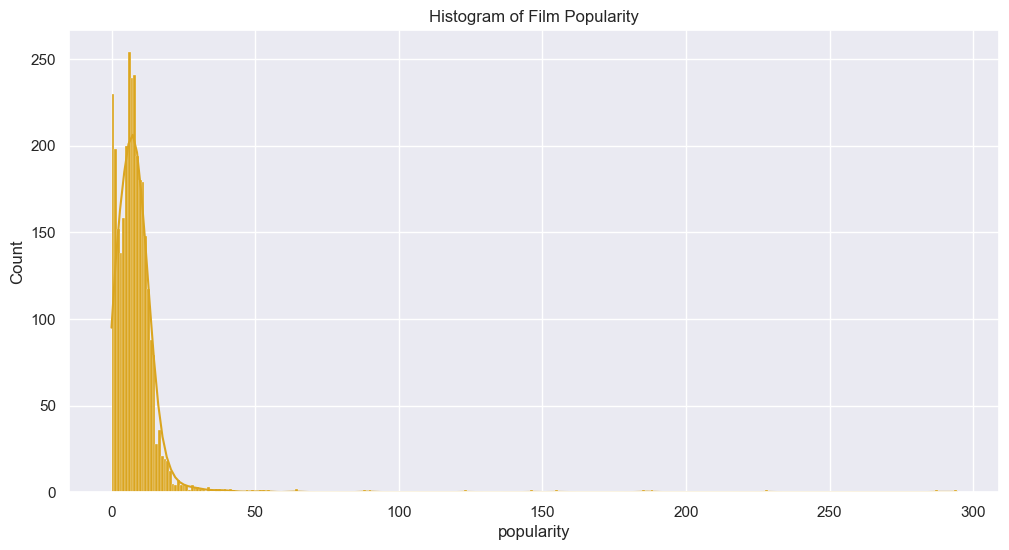

In [89]:
# Plotting the distribution of popularity with a histogram and KDE
sns.histplot(train['popularity'], kde=True, color='goldenrod', alpha=1)

# Setting figure size for the plot
sns.set(rc={'figure.figsize':(12, 2)})

# Adding title to the plot
plt.title('Histogram of Film Popularity')

# Displaying the plot
plt.show()

In [90]:
# Printing the summary statistics for the 'popularity' column
print(train['popularity'].describe())

count    3000.000000
mean        8.463274
std        12.104000
min         0.000001
25%         4.018053
50%         7.374861
75%        10.890983
max       294.337037
Name: popularity, dtype: float64


Popularity is likely to be a significant feature in predicting revenue outcomes, given its potential influence on movie viewership. This, of course, depends on whether the popularity metric refers to the pre-release 'hype' surrounding a film or post-release ratings. If it's the former, popularity should theoretically have a strong positive correlation with revenue, as higher popularity typically leads to better marketing and increased ticket sales. 

From the 3,000 films in the dataset, the average popularity is 8.46, with a minimum of 0.00 and a maximum of 294.34. The histogram shows that most films have a popularity score between 0 and 25, with a few highly popular outliers. These outliers will be addressed later in the analysis.

### Bivariate Analysis

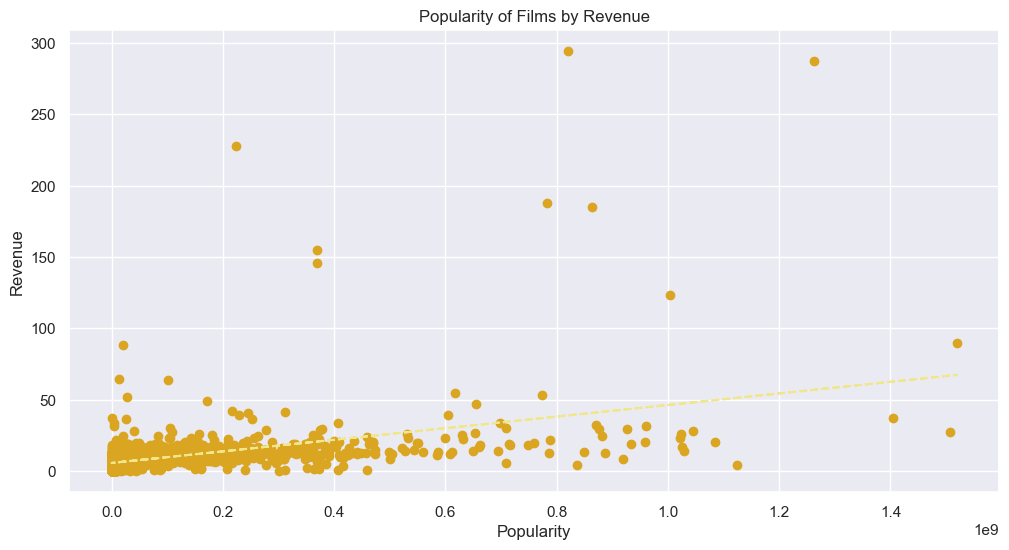

In [93]:
# Bivariate analysis: plotting popularity against revenue
sns.set(rc={'figure.figsize':(12, 6)})  # Setting figure size

# Assigning revenue and popularity to variables
cx = train['revenue']
pop = train['popularity']

# Scatter plot of revenue vs popularity
plt.plot(cx, pop, 'o', color='goldenrod')
plt.ylabel("Revenue")
plt.xlabel("Popularity")
plt.title("Popularity of Films by Revenue")

# Fitting a linear trend line to the scatter plot
z = np.polyfit(cx, pop, 1)  # Linear fit (degree 1 polynomial)
p = np.poly1d(z)  # Create a polynomial object from the fit
plt.plot(cx, p(cx), "--", color='khaki')  # Plotting the trend line
plt.show()  # Display the plot

In [94]:
# Analysis of correlation between popularity and revenue
# Calculating Pearson's correlation between popularity and revenue
corr, _ = pearsonr(train['popularity'], train['revenue'])
print('Pearson\'s correlation between popularity and revenue: %.3f' % corr)

# Calculating Pearson's correlation between log-transformed popularity and log-transformed revenue
corr, _ = pearsonr(np.log1p(train['popularity']), np.log1p(train['revenue']))
print('Pearson\'s correlation between log-transformed popularity and log-transformed revenue: %.3f' % corr)

Pearson's correlation between popularity and revenue: 0.461
Pearson's correlation between log-transformed popularity and log-transformed revenue: 0.542


When comparing popularity to revenue, we observe a general positive correlation. This is expected, as higher popularity can lead to greater viewership and, consequently, increased revenue. However, further investigation into outliers reveals that some highly popular films do not generate significantly higher revenue. This suggests that while popularity is an influential factor, it is not a perfect predictor of a film's monetary success.

Additionally, there is some ambiguity regarding the scale and origin of the popularity metric, particularly in how outliers are handled. More importantly, it seems that popularity can only be assessed after a film's release, making it less useful for studios aiming to predict box office revenue. Instead, popularity may serve better as a label for predicting audience interest or engagement, similar to predicting a movie's rating. For the purposes of this project, the popularity feature will not be included in the final model.

In [96]:
cols_to_drop.append('popularity')

### Production Companies

This column lists all the production companies involved in creating each film. Major studios, given their reputations and resources, can significantly influence a film's revenue. As a result, the involvement of well-known production companies may serve as a strong predictor for the movie’s box office performanc.


In [98]:
# Display the first 10 rows of the 'production_companies' column
print(train['production_companies'].head(10))

0    [{'name': 'Paramount Pictures', 'id': 4}, {'na...
1          [{'name': 'Walt Disney Pictures', 'id': 2}]
2    [{'name': 'Bold Films', 'id': 2266}, {'name': ...
3                                                  NaN
4                                                  NaN
5                                                  NaN
6    [{'name': 'Ghost House Pictures', 'id': 768}, ...
7                                                  NaN
8    [{'name': 'Walt Disney Pictures', 'id': 2}, {'...
9    [{'name': 'Castle Rock Entertainment', 'id': 97}]
Name: production_companies, dtype: object


Much like the genres column, the data in the production companies column is somewhat messy and requires preprocessing to make it more suitable for analysis. We will use a similar approach as with the genres, applying a regular expression to extract the studio names for cleaner data manipulation.

### Pre-processing

In [101]:
# Check for missing values in the 'production_companies' column
train['production_companies'].isna()

0       False
1       False
2       False
3        True
4        True
        ...  
2995    False
2996    False
2997    False
2998    False
2999    False
Name: production_companies, Length: 3000, dtype: bool

In [102]:
# For train dataset
train['production_companies'] = train['production_companies'].fillna('')  # Replace missing values with an empty string
train['production_companies_reform'] = train['production_companies'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))  # Extract studio names

# For test dataset
test['production_companies'] = test['production_companies'].fillna('')  # Replace missing values with an empty string
test['production_companies_reform'] = test['production_companies'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))  # Extract studio names

# For df dataset
df['production_companies'] = df['production_companies'].fillna('')  # Replace missing values with an empty string
df['production_companies_reform'] = df['production_companies'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))  # Extract studio names

The first aspect we will explore after cleaning the data is the number of production studios involved in each film. This could potentially be an interesting feature to include in our model, as the number of studios may have an impact on a film's success.

In [104]:
# Create a new column 'num_studios' to store the count of production studios
train['num_studios'] = train['production_companies_reform'].apply(lambda x: len(x))  # Count the number of studios for each movie in the train dataset
test['num_studios'] = test['production_companies_reform'].apply(lambda x: len(x))    # Count the number of studios for each movie in the test dataset
df['num_studios'] = df['production_companies_reform'].apply(lambda x: len(x))        # Count the number of studios for each movie in the df dataset

# Display the distribution of the number of studios in the training dataset
train['num_studios'].value_counts()

num_studios
1     781
2     734
3     582
4     308
5     166
0     157
6     116
7      69
8      36
9      27
10      8
11      6
15      3
12      3
14      2
13      1
16      1
Name: count, dtype: int64

### Univariate Analysis

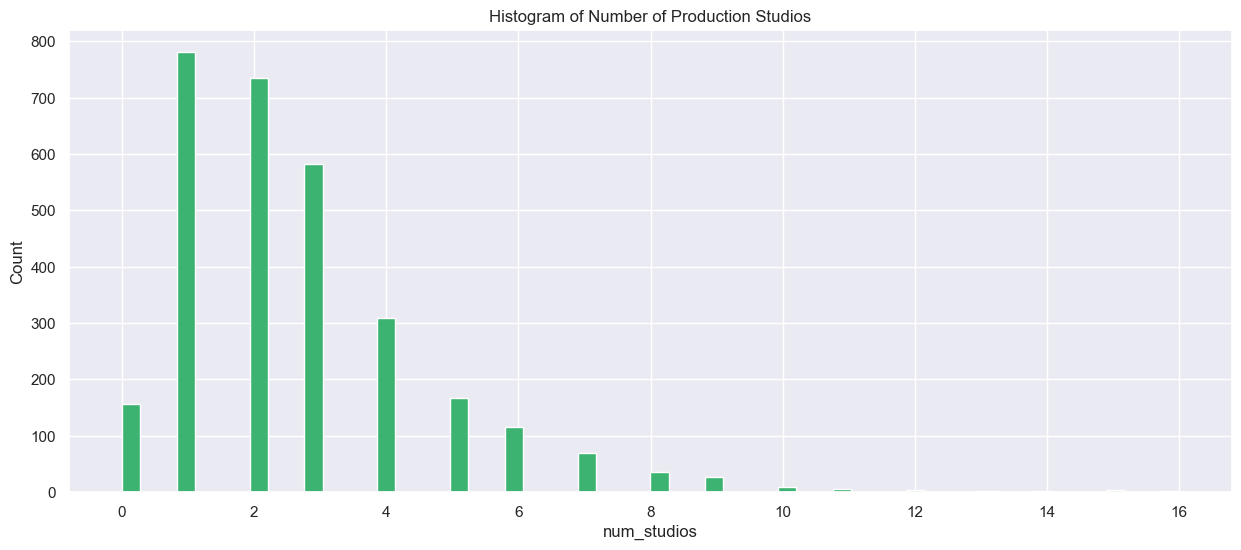

In [106]:
# Plotting films by the number of production studios
sns.set(rc={'figure.figsize': (15, 6)})  # Set figure size

# Plot histogram of the number of production studios
sns.histplot(train['num_studios'], kde=False, color='mediumseagreen', alpha=1)

# Add title to the plot
plt.title('Histogram of Number of Production Studios')

# Show the plot
plt.show()

Most movies have between 1 and 4 production studios, with fewer films having higher numbers and some even having 0 studio partners (independent films). However, simply looking at the number of production studios may not provide enough insight to make a reasonable hypothesis about a film’s box office success. 

A more effective approach would be to identify larger, more established, or historically successful production studios. By analyzing the presence of these studios in the dataset, we can better assess their impact on the box office performance of the films in question.

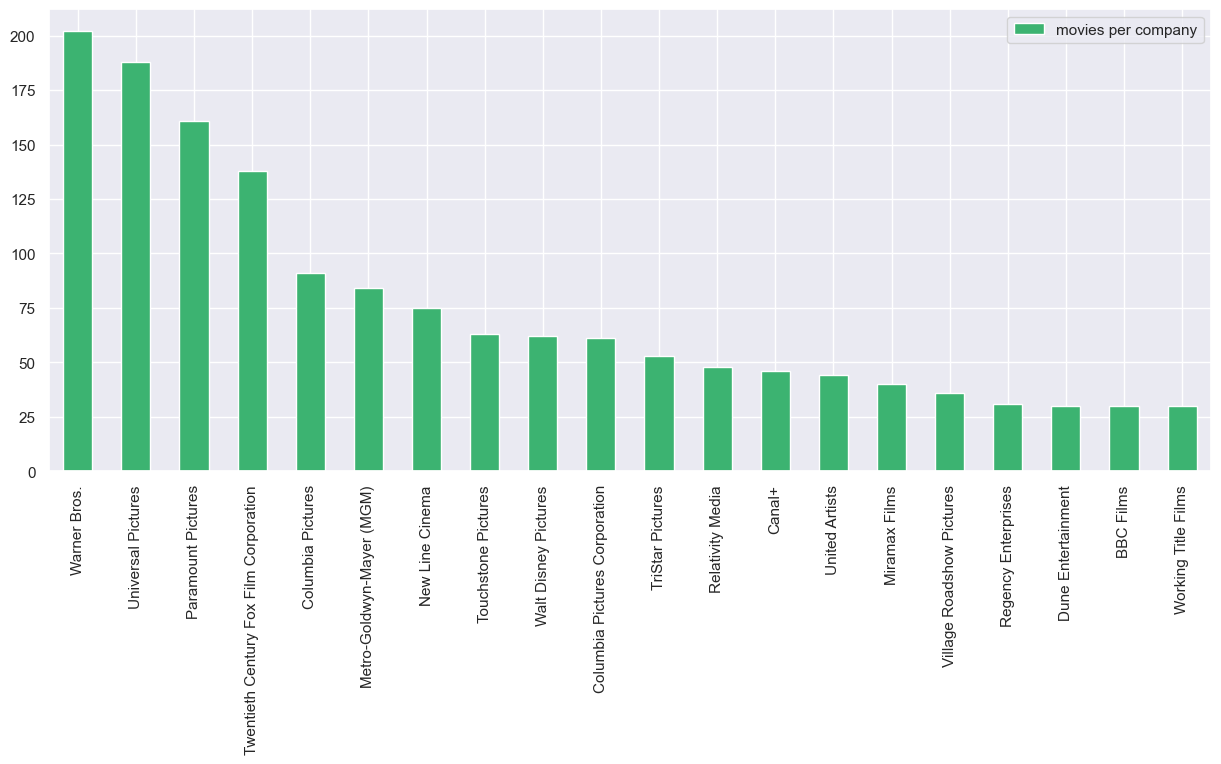

In [108]:
# Create a dictionary to count the number of movies each production company worked on
companiesDict = {}
for element in train["production_companies_reform"].values:
    for company in element:
        if company not in companiesDict:
            companiesDict[company] = 1  # If the company is not in the dict, add it
        else:
            companiesDict[company] += 1  # Otherwise, increment the count

# Convert the dictionary to a DataFrame
companies_train = pd.DataFrame.from_dict(companiesDict, orient='index', columns=["movies per company"])

# Sort the DataFrame by the number of movies each company worked on and plot the top 20 companies
companies_train.sort_values(by="movies per company", ascending=False).head(20).plot.bar(color='mediumseagreen')

# Rename the column for clarity
companies_train.columns = ["number_of_studios"]

Using the number of movies per production company may be helpful in identifying the largest studios and examining how the size of a production company influences the success of its films. There are two possibilities to consider: 

1. A larger studio has the resources and connections to attract big-name cast and crew, as well as the experience needed to turn a project into a box office success.
2. Alternatively, the studio might be too franchised, continually producing films that perform mediocrely, lacking originality or novelty.

While both scenarios are plausible, machine learning can help determine the relative influence of studio size on a movie's predicted revenue. Marking whether or not a major studio is involved in a film will serve as a useful feature in identifying this connection.

### Bivariate Analysis

In [111]:
# Count the number of movies each production studio worked on
companiesDict2 = {}
for element in df["production_companies_reform"].values:
    for company in element:
        companiesDict2[company] = companiesDict2.get(company, 0) + 1

# Convert the dictionary to a DataFrame
companies_df = pd.DataFrame.from_dict(companiesDict2, orient='index', columns=["number_of_studios"])

# Create binary columns for each production studio using pd.concat
binary_columns = pd.DataFrame({g: df['production_companies_reform'].apply(lambda x: 1 if g in x else 0) 
                               for g in companies_df.index.values}, index=df.index)

# Concatenate the binary columns with the original df at once to avoid fragmentation
df = pd.concat([df, binary_columns], axis=1)

# Calculate median, mean, and total revenue per studio
companies_df['median_rev'] = companies_df.index.map(lambda g: df[df[g] == 1]['revenue'].median())
companies_df['mean_rev'] = companies_df.index.map(lambda g: df[df[g] == 1]['revenue'].mean())
companies_df['sum_rev'] = companies_df.index.map(lambda g: df[df[g] == 1]['revenue'].sum())

# Display top 10 studios by number of studios and revenue metrics
companies_df.sort_values(by=["number_of_studios", "median_rev"], ascending=False).head(10)
companies_df.sort_values(by=["number_of_studios", "mean_rev"], ascending=False).head(10)
companies_df.sort_values(by=["number_of_studios", "sum_rev"], ascending=False).head(10)

,number_of_studios,median_rev,mean_rev,sum_rev
Warner Bros.,202,55653705.5,1.203347e+08,24307604057
Universal Pictures,188,59540581.5,1.096708e+08,20618115682
Paramount Pictures,161,52034889.0,1.247831e+08,20090073288
Twentieth Century Fox Film Corporation,138,50589532.0,1.139619e+08,15726744362
Columbia Pictures,91,77737889.0,1.202844e+08,10945881977
Metro-Goldwyn-Mayer (MGM),84,13220811.0,6.872146e+07,5772602276
New Line Cinema,75,60740827.0,1.451592e+08,10886938228
Touchstone Pictures,63,34808403.0,7.654655e+07,4822432480
Walt Disney Pictures,62,160440216.0,3.037771e+08,18834179118
Columbia Pictures Corporation,61,58853106.0,7.591135e+07,4630592046


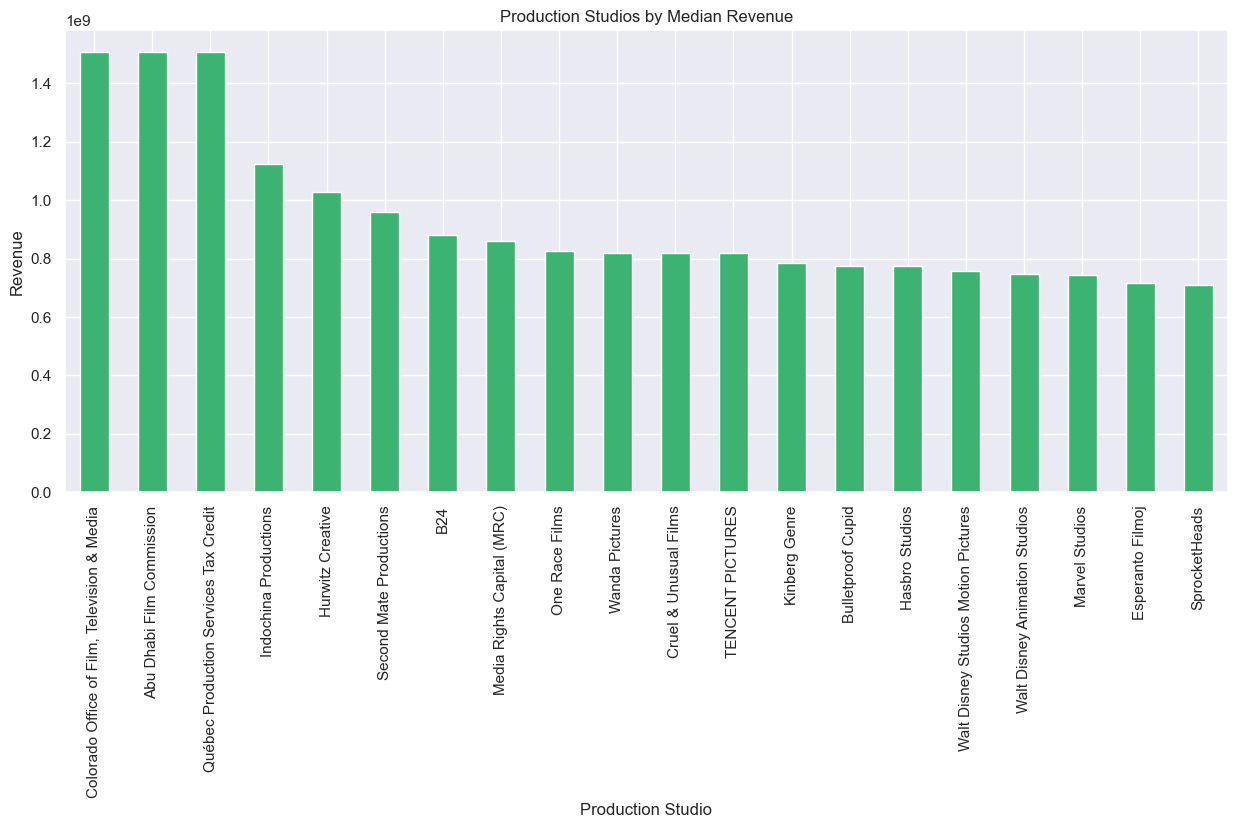

In [112]:
# Production studios by median revenue
companies_df.sort_values(by=["median_rev"], ascending=False).median_rev.head(20).plot.bar(color='mediumseagreen')

# Add title and labels to the plot
plt.title("Production Studios by Median Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

# Show the plot
plt.show()

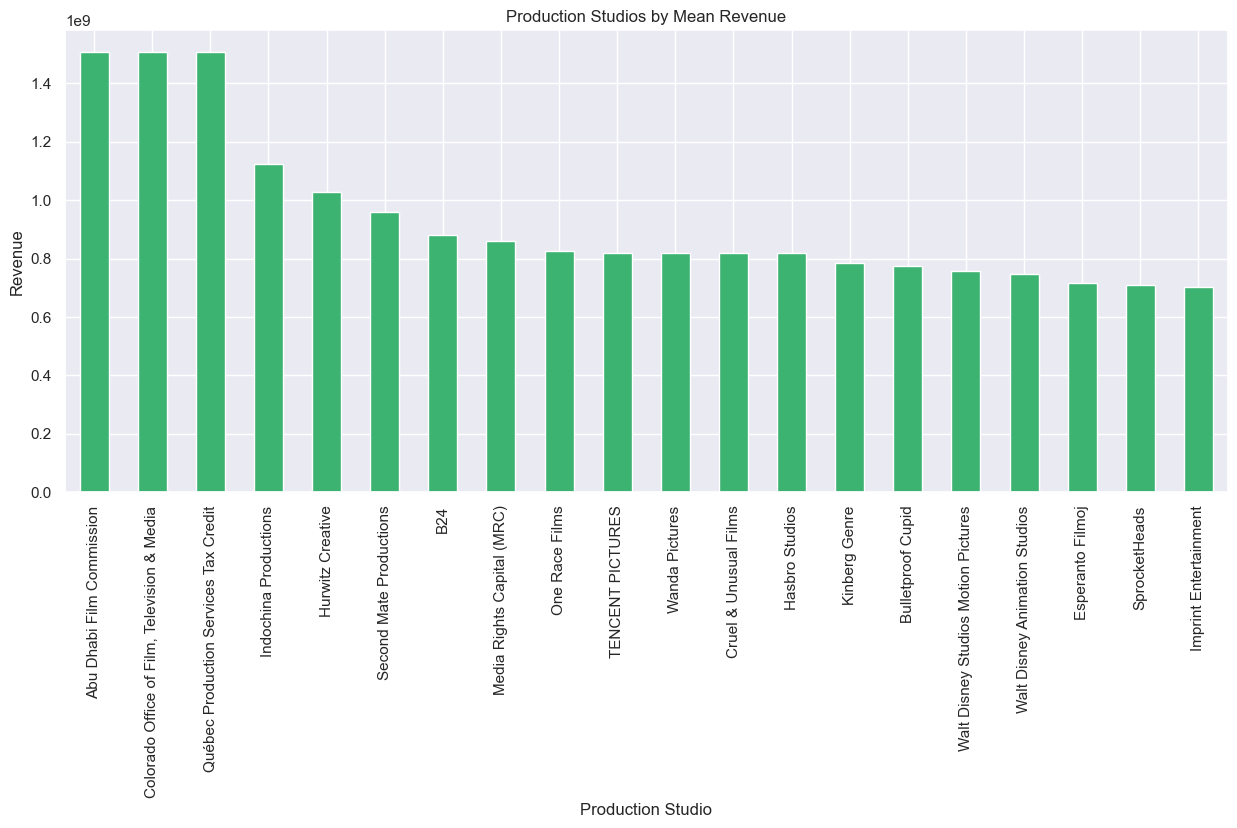

In [113]:
# Production studios by mean revenue
companies_df.sort_values(by=["mean_rev"], ascending=False).mean_rev.head(20).plot.bar(color='mediumseagreen')

# Add title and labels to the plot
plt.title("Production Studios by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

# Show the plot
plt.show()

Both mean and median revenue compared to the production studio yield relatively uninformative results. For example, the Colorado Office of Film, Television & Media appears as a minor production studio for *Furious 7* from the *Fast & Furious* franchise. This is the only time it appears on the list, significantly skewing its perceived influence on a film's revenue. Similarly, the Abu Dhabi Film Commission is involved in *Furious 7* and seven other films, including the highly profitable *Ghost Rider: Spirit of Vengeance*. These outliers are given undue importance using this system.

To improve this analysis, two approaches can be considered:

1. Analyzing the total revenue of each production company to identify the studios with the overall highest box office totals (though this may mirror the largest studios that have worked on the greatest number of films).
2. Applying the mean and median revenue values only to the primary production company working on each film, reducing the influence of minor or secondary studios on the analsis.


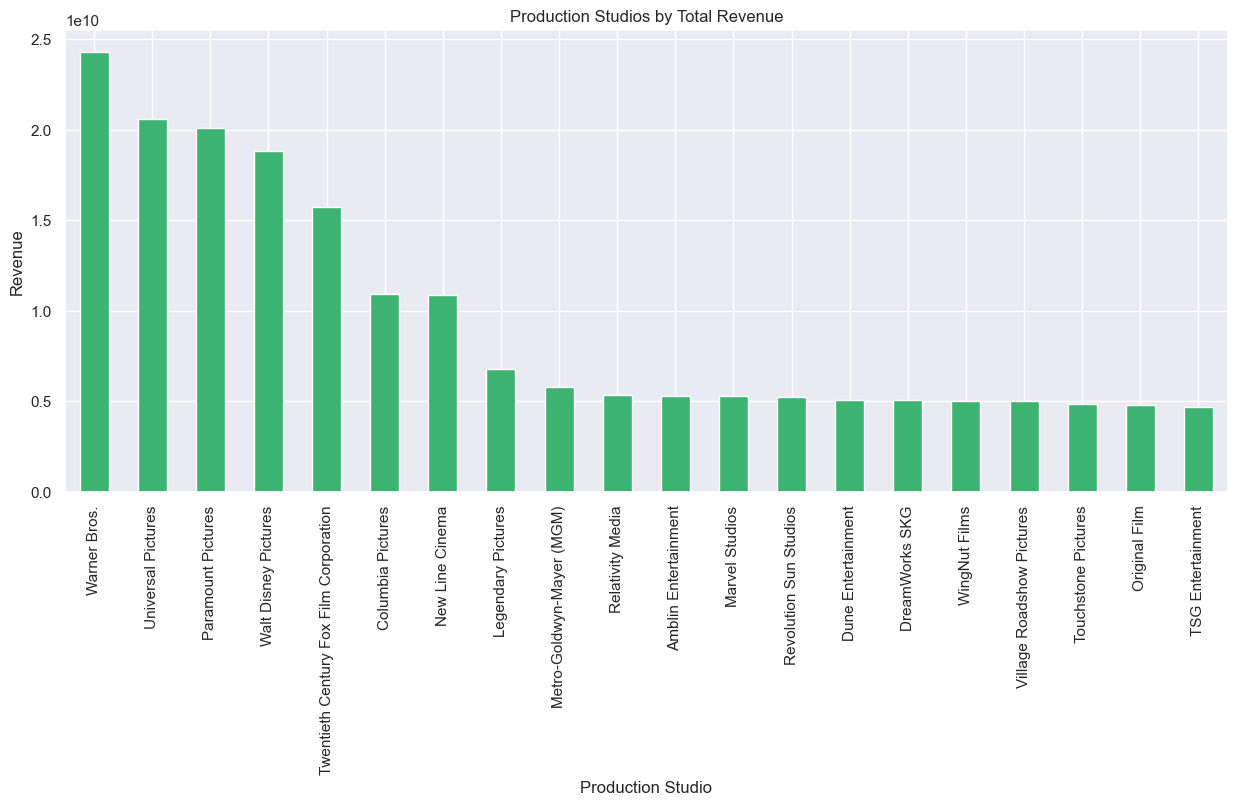

In [115]:
# Production studios by total revenue
companies_df.sort_values(by=["sum_rev"], ascending=False).sum_rev.head(20).plot.bar(color='mediumseagreen')

# Add title and labels to the plot
plt.title("Production Studios by Total Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

# Show the plot
plt.show()

As expected, the production studios largely reflect the ones with the greatest number of films produced. One notable exception is Walt Disney Pictures, which rises from ninth place in terms of films produced to fourth place in total revenue. While other studios shift positions slightly, it would be worthwhile to analyze the impact of primary production studios to gain a clearer understanding of their influence on box office success.

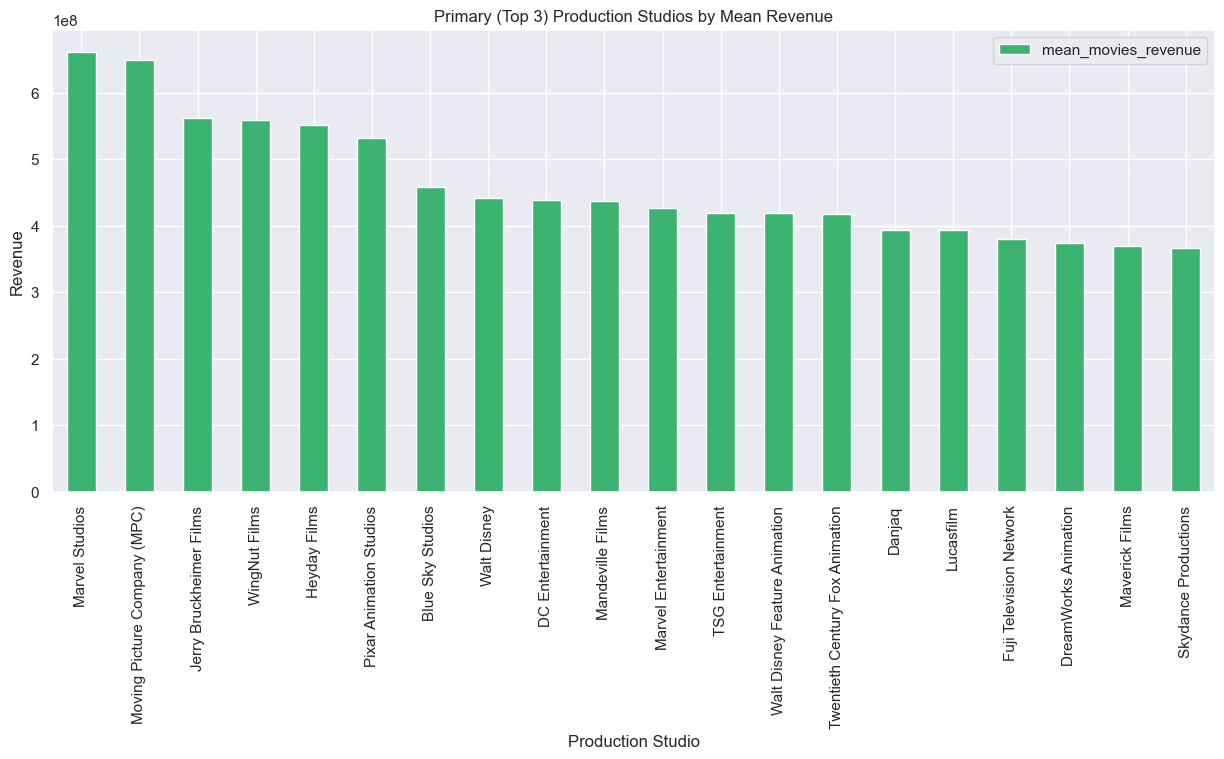

In [117]:
# Isolating the primary production studios for the films
studiosDict = {}
for element in train[["revenue", "production_companies_reform"]].values:
    # Compare results when looking at top 3 production companies in films vs. all affiliated studios
    temp = 3
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in studiosDict:
            studiosDict[element[1][i]] = [element[0], 1]
        else:
            studiosDict[element[1][i]][0] += element[0]
            studiosDict[element[1][i]][1] += 1    

# Only include studios involved in at least 3 films
studiosDict = {k: v for k, v in studiosDict.items() if v[1] >= 3}

# Calculate the mean revenue per studio
for company in studiosDict:
    studiosDict[company][0] = studiosDict[company][0] / studiosDict[company][1]
    studiosDict[company] = studiosDict[company][0]

# Create DataFrame from the dictionary and plot the top 20 studios by mean revenue
studios_train = pd.DataFrame.from_dict(studiosDict, orient='index', columns=["mean_movies_revenue"])
studios_train.sort_values(by="mean_movies_revenue", ascending=False).head(20).plot.bar(color='mediumseagreen')

# Add title and labels to the plot
plt.title("Primary (Top 3) Production Studios by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

# Show the plot
plt.show()

When isolating the top three production studios from a film's `production_companies` feature, the resulting bar plot for mean revenue by production studio shows a different picture. Notably, film commissions involved only in regional media permitting for one or a few high-revenue films (such as the Colorado Office of Film, Television & Media for *Furious 7*) are filtered out. This method provides a more accurate analysis of production studios based on mean revenue, focusing on the primary studios.

By isolating the top production studios, this approach prevents minor studios from distorting the results. It also mitigates the effect of large studios with vast filmographies, such as Warner Bros., which might otherwise be overvalued in terms of total revenue. The method ensures a more balanced analysis of production studio performance.

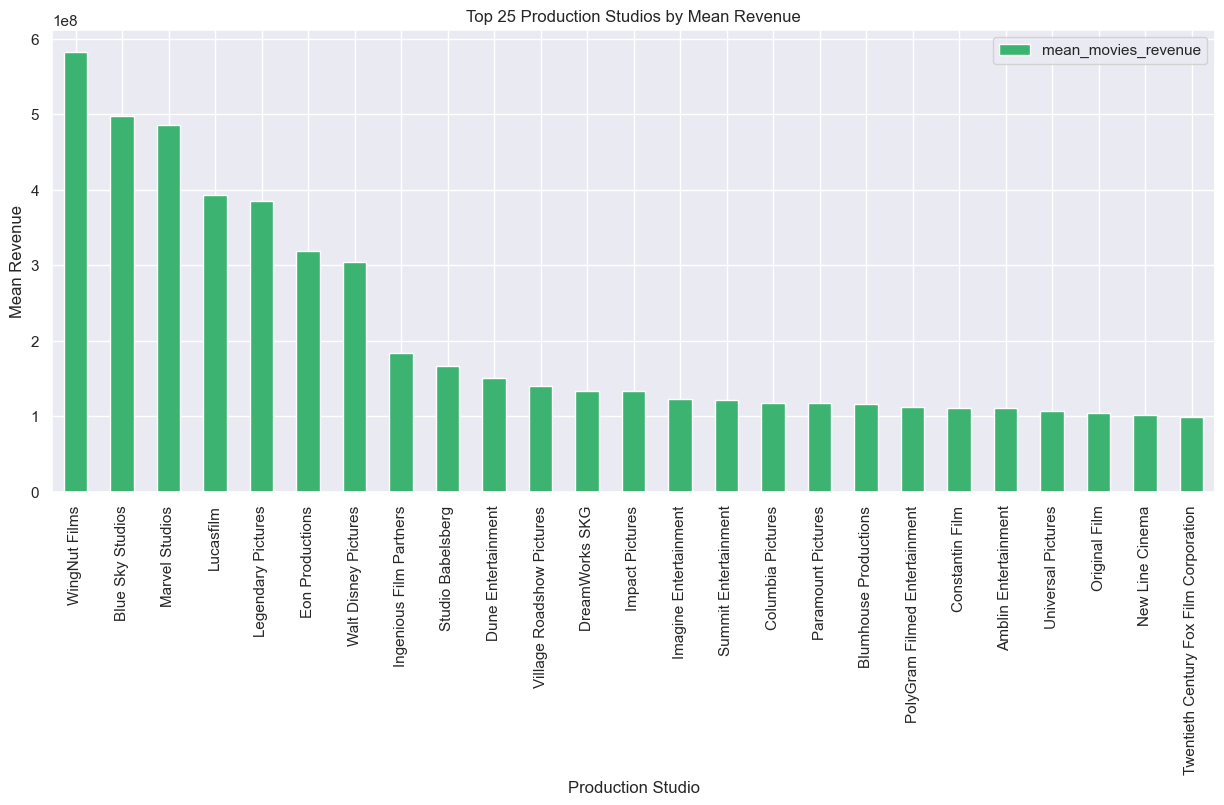

In [119]:
# Creating a dictionary for top production studios
topStudiosDict = {}
for element in train[["revenue", "production_companies_reform"]].values:
    temp = 1  # Focusing on the top studio (first studio)
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in topStudiosDict:
            topStudiosDict[element[1][i]] = [element[0], 1]  # Initialize with revenue and count
        else:
            topStudiosDict[element[1][i]][0] += element[0]  # Add revenue
            topStudiosDict[element[1][i]][1] += 1  # Increment count

# Filter out studios with fewer than 5 films
topStudiosDict = {k: v for k, v in topStudiosDict.items() if v[1] >= 5}

# Calculate the mean revenue per studio
for company in topStudiosDict:
    topStudiosDict[company][0] = topStudiosDict[company][0] / topStudiosDict[company][1]
    topStudiosDict[company] = topStudiosDict[company][0]

# Convert to DataFrame and plot the top 25 studios by mean revenue
studios_df = pd.DataFrame.from_dict(topStudiosDict, orient='index', columns=["mean_movies_revenue"])
studios_df.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='mediumseagreen')

# Show the plot
plt.title("Top 25 Production Studios by Mean Revenue")
plt.ylabel("Mean Revenue")
plt.xlabel("Production Studio")
plt.show()

In [120]:
# Sort both dictionaries to easily access the most successful studios
topStudiosDict = {k: v for k, v in sorted(topStudiosDict.items(), key=lambda item: item[1], reverse=True)}
studiosDict = {k: v for k, v in sorted(studiosDict.items(), key=lambda item: item[1], reverse=True)}

# Function to check if the lead studio is a 'top studio'
def checkTopStudios(studio):
    return 1 if len(studio) > 0 and studio[0] in list(topStudiosDict)[:50] else 0

# Function to count the number of 'top studios' in a movie
def checkStudios(studio):
    return sum(1 for company in studio[:10] if company in list(studiosDict)[:100])

# Function to calculate studio rank based on their success
def getStudioRanks(studios):
    rank = sum(list(studiosDict.keys()).index(s) for s in studios[:5] if s in studiosDict)
    return rank / len(studios) if rank > 0 else 400

# Create features for top production studios
train['topStudio'] = train['production_companies_reform'].apply(checkTopStudios)
test['topStudio'] = test['production_companies_reform'].apply(checkTopStudios)

# Create feature for number of top studios
train['numTopStudios'] = train['production_companies_reform'].apply(checkStudios)
test['numTopStudios'] = test['production_companies_reform'].apply(checkStudios)

# Create feature for studio rank
train['studioRank'] = train['production_companies_reform'].apply(getStudioRanks)
test['studioRank'] = test['production_companies_reform'].apply(getStudioRanks)

# Display value counts for the new features
print(train['topStudio'].value_counts())
print()
print(train['numTopStudios'].value_counts())
print()
print(train['studioRank'].value_counts())

topStudio
0    1682
1    1318
Name: count, dtype: int64

numTopStudios
0    2187
1     597
2     158
3      52
4       4
5       2
Name: count, dtype: int64

studioRank
400.000000    797
91.000000      52
109.000000     40
248.000000     34
101.000000     33
             ... 
33.333333       1
256.000000      1
211.250000      1
81.500000       1
67.666667       1
Name: count, Length: 983, dtype: int64


In [121]:
len(studiosDict)

399

In an effort to quantify the impact of production studios, we created two dictionaries: one for all production studios involved in the films and another for the primary studios (i.e., the first one listed for each film). Both were sorted based on the average revenue.

We then added two new columns to the dataset:
- **`topStudio`**: This column indicates whether the primary studio listed is one of the top 25 primary studios based on revenue.
- **`numTopStudios`**: This column counts the number of top studios (by revenue) that worked on a given film.

These columns help measure the influence of both the primary studio and the total number of high-revenue studios involved in a film's production.

In [123]:
# Correlation analysis for topStudio
corr, _ = pearsonr(train['topStudio'], train['revenue'])
print('Pearsons correlation between topStudio and revenue: %.3f' % corr)
corr, _ = pearsonr(train['topStudio'], np.log1p(train['revenue']))
print('Pearsons correlation between topStudio and log-transformed revenue: %.3f' % corr)
print()

# Correlation analysis for numTopStudios
corr, _ = pearsonr(train['numTopStudios'], train['revenue'])
print('Pearsons correlation between numTopStudios and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['numTopStudios']), np.log1p(train['revenue']))
print('Pearsons correlation between numTopStudios and log-transformed revenue: %.3f' % corr)
print()

# Correlation analysis for studioRank
corr, _ = pearsonr(train['studioRank'], train['revenue'])
print('Pearsons correlation between studioRank and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['studioRank']), np.log1p(train['revenue']))
print('Pearsons correlation between log-transformed studioRank and log-transformed revenue: %.3f' % corr)
print()

# Correlation analysis for num_studios
corr, _ = pearsonr(train['num_studios'], train['revenue'])
print('Pearsons correlation between num_studios and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_studios']), np.log1p(train['revenue']))
print('Pearsons correlation between log-transformed num_studios and log-transformed revenue: %.3f' % corr)

Pearsons correlation between topStudio and revenue: 0.320
Pearsons correlation between topStudio and log-transformed revenue: 0.436

Pearsons correlation between numTopStudios and revenue: 0.558
Pearsons correlation between numTopStudios and log-transformed revenue: 0.419

Pearsons correlation between studioRank and revenue: -0.334
Pearsons correlation between log-transformed studioRank and log-transformed revenue: -0.451

Pearsons correlation between num_studios and revenue: 0.154
Pearsons correlation between log-transformed num_studios and log-transformed revenue: 0.269


We observe a moderate positive correlation between our created columns used to quantify the top studios, which is encouraging as it may suggest some predictive ability for revenue. Additionally, there is a weaker positive correlation between the number of studios involved in a film and its revenue. This indicates that while the involvement of more studios has some impact, it is not as strongly correlated as the influence of top studios.

In [125]:
train_features.append('topStudio')
log_features.append('numTopStudios')
log_features.append('num_studios')
log_features.append('studioRank')

### Additional Feature Engineering and Creation

Now we will revisit the budget and revenue columns. Both of these features contain numerous values that appear to be garbage data, which is critical to our model's success. Previously, we replaced these bad values with the median, but due to the high number of replacements needed, we require a more effective solution.

Instead, we will calculate the average budget and revenue for all studios associated with each film, as this is likely to provide a more accurate reflection of a movie's financials. The following functions will replace all budgets and revenues under $10,000 in our training set.

In [127]:
def getAvgStudioRev(movie):
    # Adjust the budget if it's less than $10,000
    if movie.budget < 10000: 
        if len(movie.production_companies_reform) > 0:
            studios = movie.production_companies_reform
            median_revs = []
            
            # Gather median revenue for all studios involved in the movie
            for studio in studios:
                if studio in companies_df.index:
                    median_revs.append(float(companies_df.loc[studio]['median_rev']))
            
            # If median revenue data is available and reasonable, use the average of these values
            if len(median_revs) > 0 and mean(median_revs) > 10000:
                movie.budget_processed = mean(median_revs)
            else:
                movie.budget_processed = train.budget.median()  # Default to median budget if no valid data
        else:
            movie.budget_processed = train.budget.median()
    
    # Adjust the revenue if it's less than $10,000
    if 'revenue' in movie and movie.revenue < 10000 and len(movie.production_companies_reform) > 0:
        studios = movie.production_companies_reform
        median_revs = []
        
        # Gather median revenue for all studios involved
        for studio in studios:
            if studio in companies_df.index:
                median_revs.append(float(companies_df.loc[studio]['median_rev']))
        
        # If valid median revenue data is available, update the revenue
        if len(median_revs) > 0 and mean(median_revs) > 10000:
            movie.revenue = mean(median_revs)
        else:
            movie.revenue = train.revenue.median()  # Default to median revenue if no valid data
        
    return movie

In [128]:
# Applying the getAvgStudioRev function to train and test datasets
train = train.apply(getAvgStudioRev, axis=1)
test = test.apply(getAvgStudioRev, axis=1)

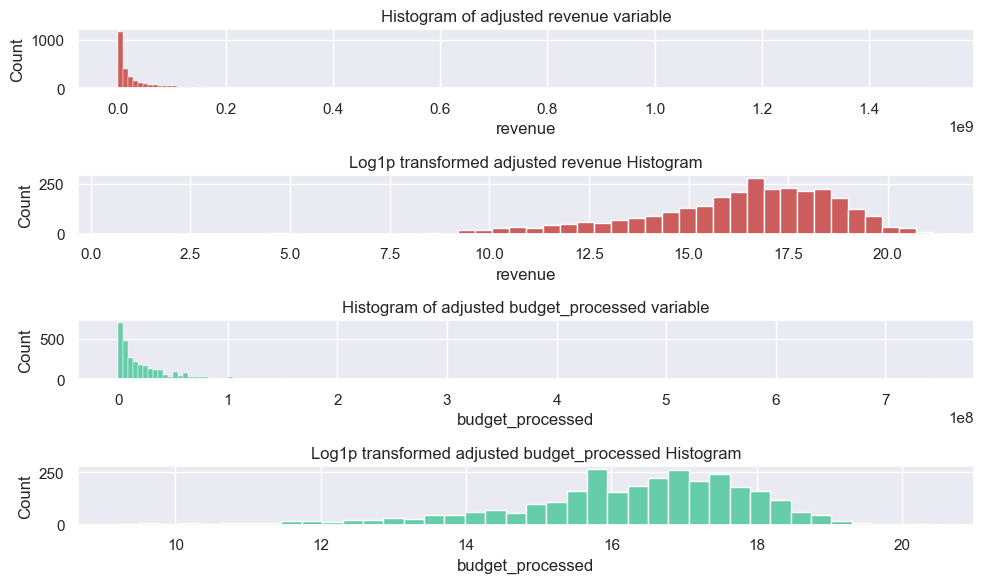

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plot histograms for revenue and budget variables
f, ax = plt.subplots(4, figsize=(10, 6))

sns.set(rc={'figure.figsize': (12, 8)})

# Plot histogram of adjusted revenue variable
sns.histplot(x=train.revenue, kde=False, ax=ax[0], color='indianred', alpha=1)
ax[0].set_title("Histogram of adjusted revenue variable")

# Plot log1p transformed adjusted revenue histogram
sns.histplot(x=np.log1p(train.revenue), kde=False, ax=ax[1], color='indianred', alpha=1)
ax[1].set_title("Log1p transformed adjusted revenue Histogram")

# Plot histogram of adjusted budget_processed variable
sns.histplot(x=train.budget_processed, kde=False, ax=ax[2], color='mediumaquamarine', alpha=1)
ax[2].set_title("Histogram of adjusted budget_processed variable")

# Plot log1p transformed adjusted budget_processed histogram
sns.histplot(x=np.log1p(train.budget_processed), kde=False, ax=ax[3], color='mediumaquamarine', alpha=1)
ax[3].set_title("Log1p transformed adjusted budget_processed Histogram")

# Adjust the layout
f.tight_layout()

# Show the plot
plt.show()

After the adjustments, the distributions look much better. While there are still a number of lower values that may not be entirely accurate, we do not want to alter the values too drastically. Ideally, we would retrieve the true revenues and budgets, but for now, we will rely on the data provided.

Next, we need to account for how movies have changed over time and adjust for inflation, as our dataset includes movies dating back to the 1960s. To handle this, we will create two additional features:
1. **Budget-to-year ratio**: This will help adjust for the changes in production budgets over time.
2. **Runtime-to-year ratio**: This will capture how the average runtime of movies has evolved over the decades.

These two variables are expected to be the most useful, as both budget and runtime have likely seen the greatest amount of change over the past few decades of filmmking.


In [131]:
# Ensure the release_date column is in datetime format
# Assuming release_date is in "YYYY-MM-DD" format
train['release_date'] = pd.to_datetime(train['release_date'], format='%Y-%m-%d', errors='coerce')
test['release_date'] = pd.to_datetime(test['release_date'], format='%Y-%m-%d', errors='coerce')

# Extract year from the release_date
train['year'] = train['release_date'].dt.year
test['year'] = test['release_date'].dt.year

In [132]:
# Create budget-to-year ratio and runtime-to-year ratio
train['budget_to_year_ratio'] = train['budget_processed'] / (train['year'] * train['year'])
test['budget_to_year_ratio'] = test['budget_processed'] / (test['year'] * test['year'])

train['runtime_to_year_ratio'] = train['runtime'] / train['year']
test['runtime_to_year_ratio'] = test['runtime'] / test['year']

# Append to log features
log_features.append('budget_to_year_ratio')
log_features.append('runtime_to_year_ratio')

### Feature Selection
After thoroughly exploring the dataset and creating several new features for our model, it’s time to analyze the results and finalize the set of features to be included in the model. By selecting the most relevant features, we aim to improve the predictive performance while avoiding overfitting and reducing computational complexity. We will evaluate both the original and newly created features to determine their significance and relevance to our final model.


In [134]:
# Initial list of columns to drop
cols_to_drop = ['imdb_id', 'original_title', 'overview']

# List of additional columns to add
additional_cols = ['poster_path', 'status', 'popularity']

# Use extend() to add multiple columns to cols_to_drop
cols_to_drop.extend(additional_cols)

# Check the updated list
print(cols_to_drop)

['imdb_id', 'original_title', 'overview', 'poster_path', 'status', 'popularity']


### Dropping Unnecessary Columns
To streamline our dataset, we dropped columns that are either irrelevant or not useful for predictive modeling. These include:
- **imdb_id**: An identifier that doesn’t add predictive value.
- **original_title**: The title of the movie, which is not directly useful for numerical modeling.
- **overview**: A textual description that is not easily quantified.
- **poster_path**: A reference to an image, irrelevant for our analysis.
- **status**: Status of the movie (e.g., "Released"), which is redundant for prediction since all movies in the dataset are already released.
  
These columns were dropped to avoid unnecessary noise and to focus on features that contribute more directly to revenue prediction.

In [136]:
print(train_features)

['belongs_to_collection', 'topStudio']


These are the dummy variables that will be used in our model. Additionally, we need to apply log transformation to all of the numerical features to ensure better performance and handling of skewed data.

In [138]:
print(log_features)

['revenue', 'budget_processed', 'genre_rank', 'num_genres', 'numTopStudios', 'num_studios', 'studioRank', 'budget_to_year_ratio', 'runtime_to_year_ratio']


We will log transform all of these features and include them in our set of features for the model.

In [140]:
# Loop through each feature in the log_features list
for feat in log_features:
    # Apply log transformation to the train set for the current feature
    # np.log1p() is used to handle zero values by applying log(1 + x)
    train["log_" + feat] = np.log1p(train[feat])
    
    # Skip 'revenue' for the test set, as it's typically the target variable (not present in the test set)
    if feat != "revenue":
        # Apply log transformation to the test set for the current feature
        test["log_" + feat] = np.log1p(test[feat])
        
        # Add the newly created log-transformed feature to the train_features list
        train_features.append("log_" + feat)

Now that we have created log-transformed features for all the desired variables, this will be our final list of features for the model. Let's take a look at the complete list.

In [142]:
# Print the list of training features and the number of features
print(train_features)
print()
print("Number of features: ", len(train_features))

['belongs_to_collection', 'topStudio', 'log_budget_processed', 'log_genre_rank', 'log_num_genres', 'log_numTopStudios', 'log_num_studios', 'log_studioRank', 'log_budget_to_year_ratio', 'log_runtime_to_year_ratio']

Number of features:  10


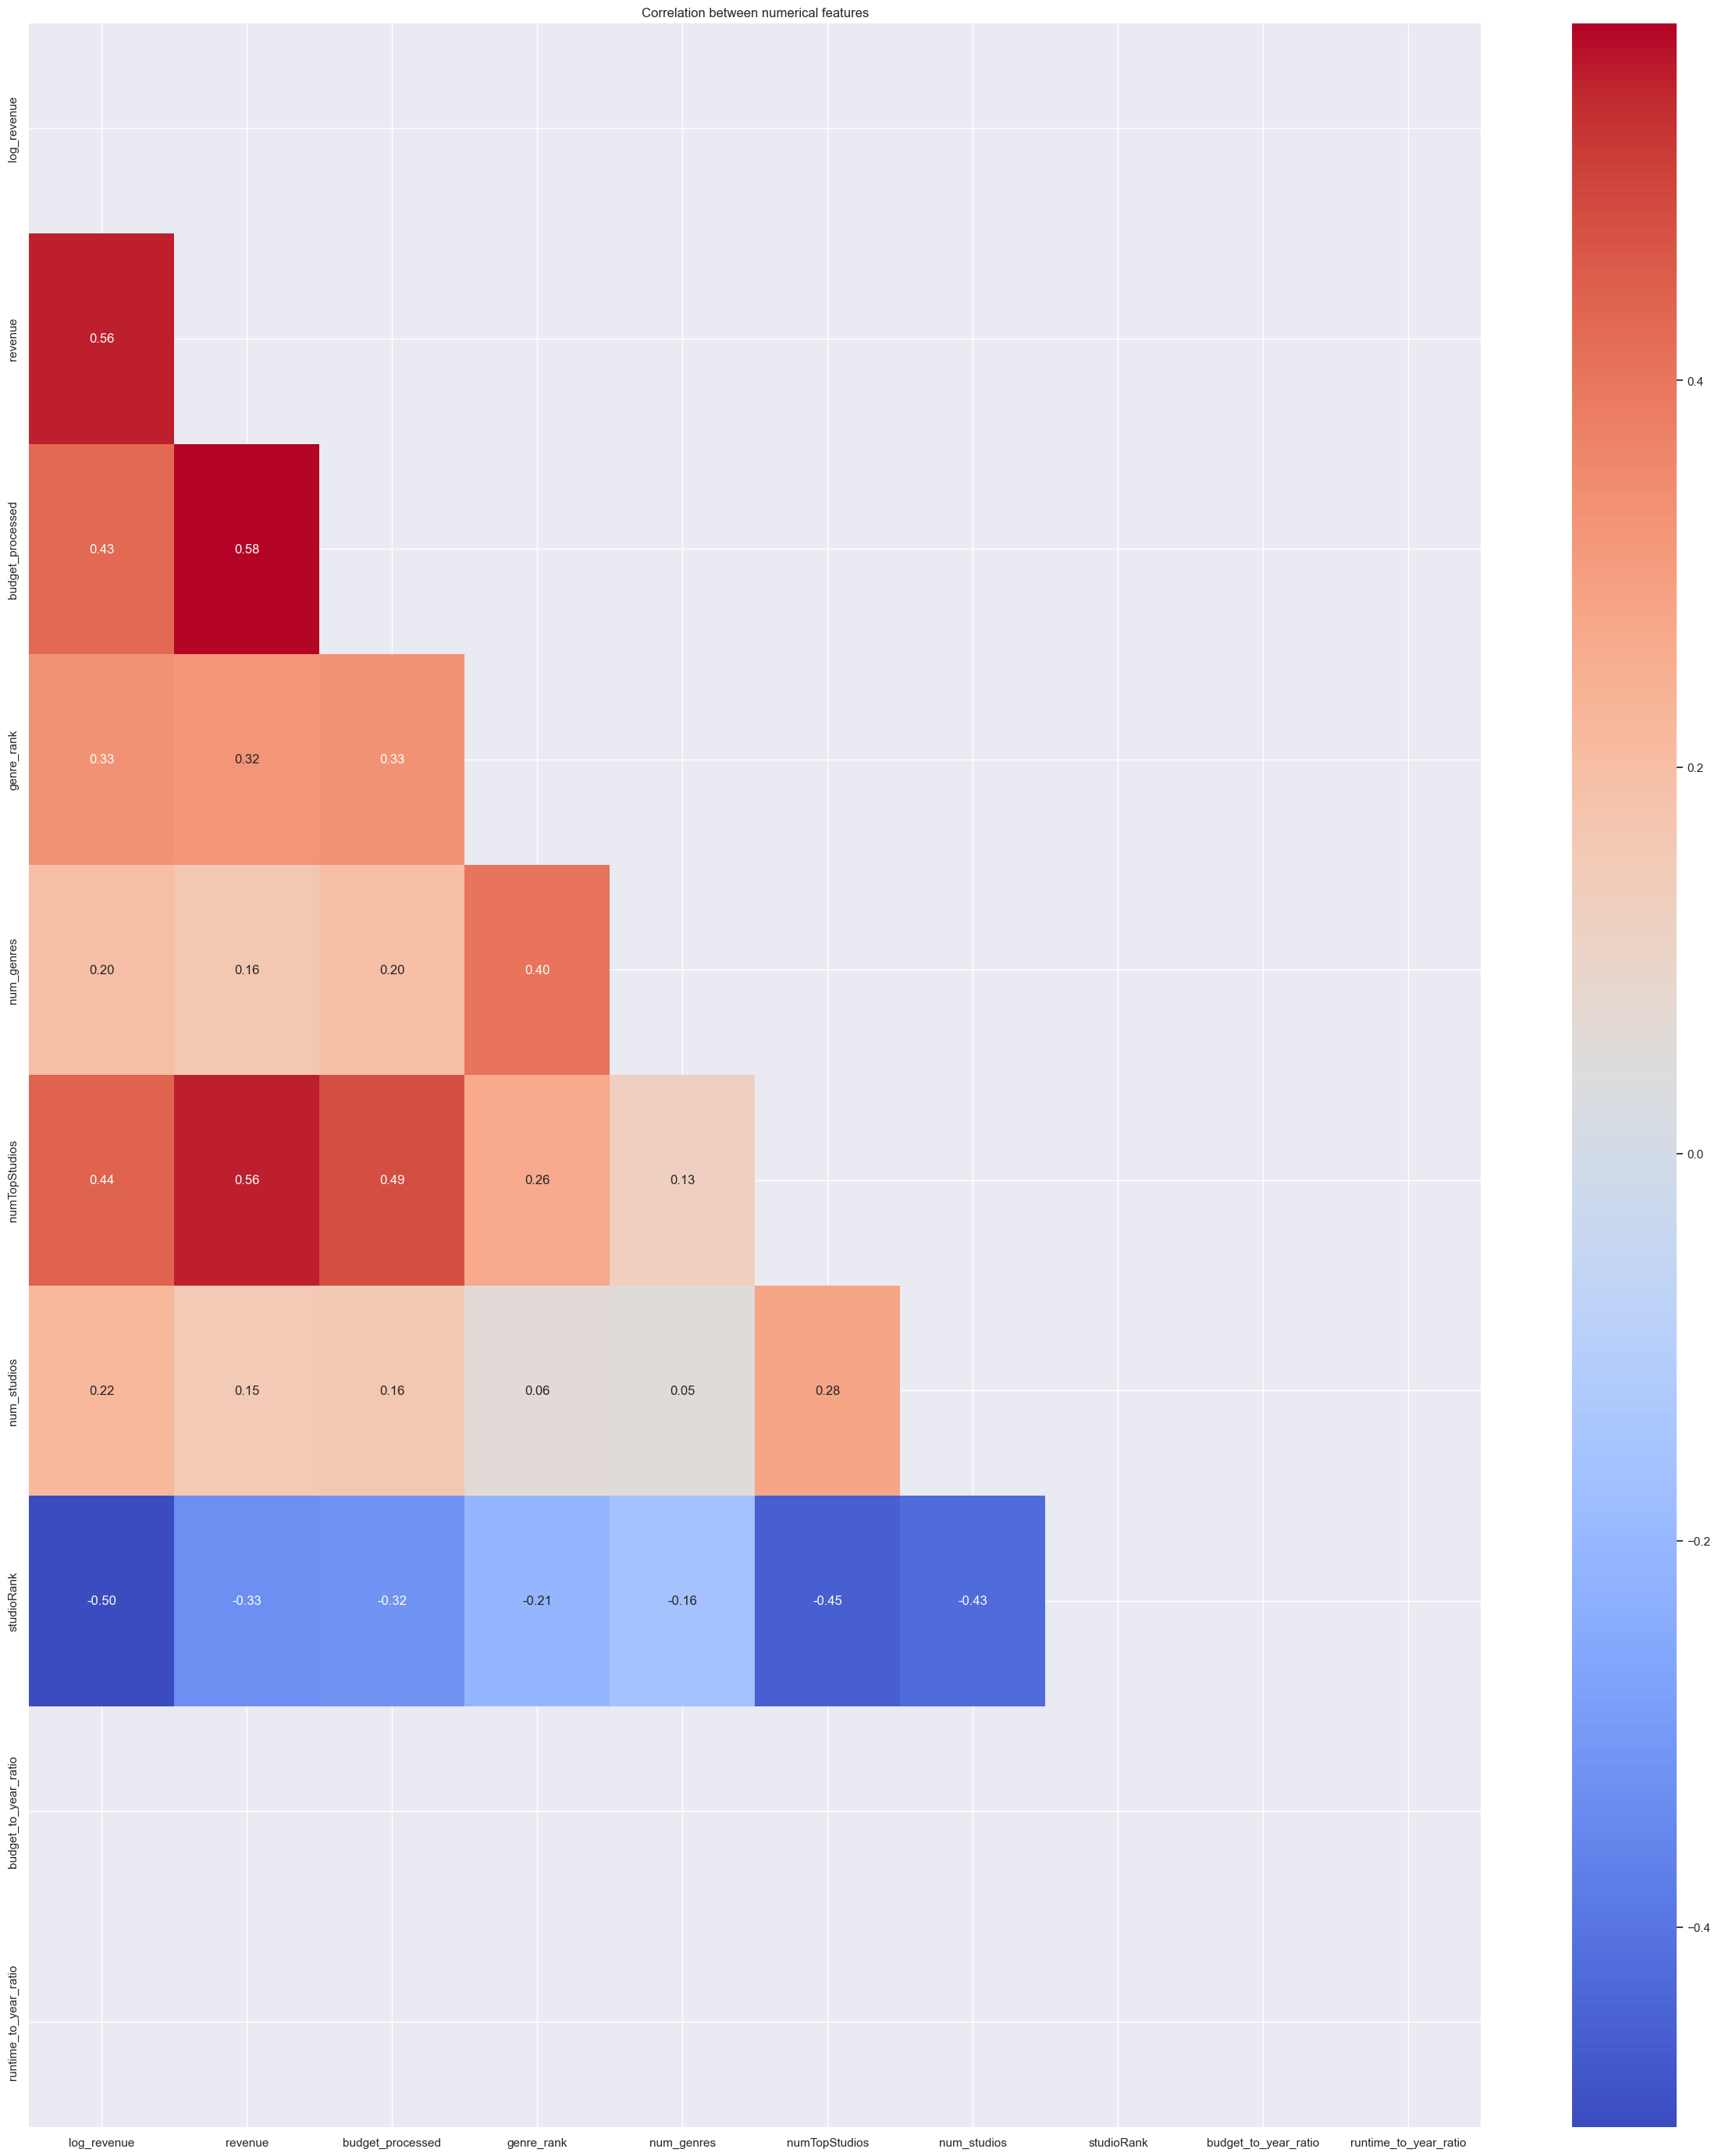

In [143]:
# Correlation matrix for numerical features
sns.set(rc={'figure.figsize':(30,35)})

# Compute the correlation matrix
corr = train[['log_revenue', *log_features]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the heatmap
sns.heatmap(corr, mask=mask, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm')

plt.title("Correlation between numerical features")
plt.show()

The correlation matrix provides valuable insights into the relationships between our numerical features. Looking at the leftmost column, we can observe the correlations between **revenue** and other variables, with **budget** showing a strong positive correlation. This indicates that budget is one of the most influential factors in predicting revenue. However, we also notice some degree of multicollinearity among the variables, particularly between **num_genres** and **num_top_studios**, as well as **runtime_to_year_ratio**. This suggests that some features are highly related to each other, which could introduce complexity into our models. While linear regression was initially considered, this multicollinearity pushes us towards more robust models, such as tree-based algorithms like **LightGBM** and **Random Forest**, which are less sensitive to correlated features.


### Modeling

Now that we have our final list of features, we can start modeling. We will begin by setting up our `X` and `y`, followed by creating a train/test split on our data. The data will be split into 80% for training and 20% for testing (as a validation set).

In [147]:
# Set up X and y for modeling
X = train[train_features]
y = train['log_revenue']

# Create an 80/20 stratified split of the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)

# Ensure the dimensions are correct
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (2400, 10) (2400,)
Test set: (600, 10) (600,)


Next, we will define a few helper functions for efficiency and organization. The first function will perform a grid search for hyperparameter tuning on each of our models. The second function will evaluate and compare our baseline model to the tuned model, showing us the percent difference. Lastly, the third function will output several key metrics to judge the performance of our models.

In [149]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_root_mean_squared_error',
                       do_probabilities=False):
    # Perform Grid Search with Cross Validation
    gs = GridSearchCV(
        estimator=model,          # The model to optimize
        param_grid=param_grid,     # The parameter grid for hyperparameter tuning
        cv=cv,                    # Number of cross-validation folds
        n_jobs=-1,                # Use all processors for parallel processing
        scoring=scoring_fit,      # Metric to optimize, e.g., 'neg_root_mean_squared_error'
        verbose=2                 # Show detailed output during the search
    )
    
    # Fit the model on the training data
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    # Make predictions - choose between probabilities or standard predictions
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)  # Used for classification problems
    else:
        pred = fitted_model.predict(X_test_data)  # Used for regression problems
    
    return fitted_model, pred

In [150]:
def evaluate(model, test_features, test_labels):
    # Make predictions on the test set
    predictions = model.predict(test_features)
    
    # Calculate absolute errors
    errors = abs(predictions - test_labels)
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = 100 * np.mean(errors / test_labels)
    
    # Calculate accuracy as 100 - MAPE
    accuracy = 100 - mape
    
    # Print the results
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.3f}%'.format(accuracy))
    
    return accuracy

In [151]:
def metrics(y_pred, y_test):
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Calculate Mean Absolute Error (MAE)
    errors = abs(y_pred - y_test)
    mae = np.mean(errors)
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = 100 * (errors / y_test)
    
    # Print the metrics
    print('Mean Squared Error: ', round(mse, 4))
    print('Root Mean Squared Error: ', round(rmse, 4))
    print('Mean Absolute Error: ', round(mae, 4))
    
    # Calculate and display accuracy based on MAPE
    test_accuracy = 100 - np.mean(mape)
    print('Test Set Accuracy (from Mean Absolute Percentage Error): {:.3f}%'.format(test_accuracy))

### Random Forest Model

We will start with the **Random Forest** algorithm, an ensemble learning method that constructs multiple decision trees during training. Each tree makes its own prediction, and the final prediction is determined by averaging the outputs of all the individual trees. This approach improves accuracy and reduces errors that may occur when relying on a single decision tree, as it helps mitigate overfitting and captures a broader range of data patterns.

In [153]:
rfr_base_model = RandomForestRegressor(random_state=42)
rfr_base_model.fit(X_train, y_train.values.ravel())

RandomForestRegressor(random_state=42)

In [154]:
y_pred = rfr_base_model.predict(X_test)

In [155]:
errors = abs(np.expm1(y_pred) - np.expm1(y_test.values))
# Print out the mean absolute error (MAE)
print('Average Error:', round(np.mean(errors), 2))

Average Error: 40215249.17


In [156]:
print('Random Forest Baseline Model Metrics:')
metrics(y_pred, y_test.values)

Random Forest Baseline Model Metrics:
Mean Squared Error:  2.9168
Root Mean Squared Error:  1.7079
Mean Absolute Error:  1.2236
Test Set Accuracy (from Mean Absolute Percentage Error): 90.829%


### Grid Search Hyperparameter Tuning

We use Grid Search to find the optimal hyperparameter combination that maximizes model performance.

In [158]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 25, 30],
    'max_features': [0.4, 'sqrt', 'log2'],  # Remove 'auto' and use valid strings or a float
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 3, 5],  # Replace 1 with 2 since min_samples_split must be >= 2
    'n_estimators': [100, 400]
}

# Create a based model
rfr = RandomForestRegressor(random_state=42)
# Instantiate the grid search model
rfr, pred = algorithm_pipeline(X_train, X_test, y_train.values.ravel(), y_test.values, rfr, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-rfr.best_score_))
print(rfr.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
1.3004103477503663
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.4, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 400}


In [159]:
print('Base Model:')
base_accuracy = evaluate(rfr_base_model, X_test, y_test.values)
print()
print('Model after Tuning:')
rfr_best_model = rfr.best_estimator_
best_accuracy = evaluate(rfr_best_model, X_test, y_test.values)

Base Model:
Average Error: 1.2236
Accuracy = 90.829%

Model after Tuning:
Average Error: 1.2011
Accuracy = 90.830%


### LightGBM
**LightGBM**, a gradient boosting framework similar to XGBoost but designed for improved speed and efficiency. LightGBM is lightweight, consumes less memory, and is particularly effective for large-scale datasets. Let's evaluate its performance on our data.

In [161]:

# Initialize the LGBMRegressor with a random state for reproducibility
lgbm_base_model = LGBMRegressor(random_state=42)

# Fit the model to the training data (X_train and y_train)
# We use .ravel() to ensure the target data is in the correct shape
lgbm_base_model.fit(X_train, y_train.values.ravel())

# Make predictions on the test set (X_test)
y_pred = lgbm_base_model.predict(X_test)

# Now you can evaluate the predictions (using your evaluation metrics from earlier)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 8
[LightGBM] [Info] Start training from score 16.208053


In [162]:
# Print a message indicating that we are displaying the metrics for the LightGBM model
print('LightGBM Baseline Model Metrics:')

# Calculate and display the evaluation metrics for the LightGBM model
# 'y_pred' contains the predicted values from the LightGBM model
# 'y_test.values' contains the actual target values from the test set
metrics(y_pred, y_test.values)

LightGBM Baseline Model Metrics:
Mean Squared Error:  2.9026
Root Mean Squared Error:  1.7037
Mean Absolute Error:  1.2044
Test Set Accuracy (from Mean Absolute Percentage Error): 90.858%


### Grid Search Hyperparameter Tuning

We use Grid Search to find the optimal hyperparameter combination that maximizes model performance.

In [164]:
# Create the parameter grid for LightGBM based on the results of random search
param_grid = {
    'n_estimators': [100],  # Reduce the number of estimators to one value
    'colsample_bytree': [0.8, 1.0],  # Keep two values here
    'max_depth': [-1, 5],  # Reduce the number of values for faster search
    'reg_alpha': [0.5],  # Single value for L1 regularization
    'reg_lambda': [0.3],  # Single value for L2 regularization
    'subsample': [0.8],  # Single value for subsampling
    'num_leaves': [31],  # Single value for num_leaves
}

# Create a base model for LightGBM
lgbm = LGBMRegressor(random_state=42)

# Use the algorithm_pipeline function for hyperparameter tuning using grid search
lgbm, pred = algorithm_pipeline(X_train, X_test, y_train.values.ravel(), y_test.values, lgbm, 
                                 param_grid, cv=5)

# Print the Root Mean Squared Error (RMSE) of the best model
print(np.sqrt(-lgbm.best_score_))

# Print the best hyperparameters found by the grid search
print(lgbm.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 8
[LightGBM] [Info] Start training from score 16.208053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [165]:
# Initialize a basic LGBMRegressor model (no hyperparameter tuning)
lgbm_base_model = LGBMRegressor()

# Train the base model using the training data
lgbm_base_model.fit(X_train, y_train.values.ravel())

# Evaluate the base model's accuracy on the test data
base_accuracy = evaluate(lgbm_base_model, X_test, y_test.values)

# Retrieve the best model found by RandomizedSearchCV (lgbm.best_estimator_)
lgbm_best_model = lgbm.best_estimator_

# Evaluate the best model's accuracy on the test data
best_accuracy = evaluate(lgbm_best_model, X_test, y_test.values)

# Calculate the improvement percentage from the base model to the tuned model
improvement = 100 * (best_accuracy - base_accuracy) / base_accuracy

# Print the percentage improvement
print('Improvement of {:0.2f}%.'.format(improvement))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 8
[LightGBM] [Info] Start training from score 16.208053
Average Error: 1.2044
Accuracy = 90.858%
Average Error: 1.1845
Accuracy = 90.987%
Improvement of 0.14%.


In [258]:
# Use the best LightGBM model (after hyperparameter tuning) to make predictions on the test set
y_pred = lgbm_best_model.predict(X_test)

# Print the evaluation metrics for the LightGBM model after tuning
print('LightGBM Model (After Tuning) Metrics:')

# Call the metrics function to evaluate the predictions and compare them with the true values
metrics(y_pred, y_test.values)

LightGBM Model (After Tuning) Metrics:
Mean Squared Error:  2.8466
Root Mean Squared Error:  1.6872
Mean Absolute Error:  1.1845
Test Set Accuracy (from Mean Absolute Percentage Error): 90.987%


In [260]:
# Calculate and print the average error of the LightGBM model after converting predictions back from log1p scale
print('Average error of LightGBM: ${:.2f}'.format(
    np.mean(abs(np.expm1(lgbm_best_model.predict(X_test)) - np.expm1(y_test.values)))
))

# Calculate and print the average error of the Random Forest model after converting predictions back from log1p scale
print('Average error of Random Forest: ${:.2f}'.format(
    np.mean(abs(np.expm1(rfr_best_model.predict(X_test)) - np.expm1(y_test.values)))
))

Average error of LightGBM: $40812970.09
Average error of Random Forest: $41022113.34


### Model Comparison: LightGBM vs Random Forest

After tuning both the **LightGBM** and **Random Forest** models, we observed the following average errors:

- **LightGBM**:  
  - Average error: **$40812970.09**

- **Random Forest**:  
  - Average error: **$41022113.34**

### Conclusion:
The **LightGBM** model significantly outperforms the **Random Forest** model on our dataset, achieving a much lower average error. This result suggests that LightGBM is better suited for this particular task, likely due to its efficiency in handling large-scale data and its ability to better capture complex patterns. The difference in performance highlights the effectiveness of gradient boosting techniques, particularly LightGBM, for tasks like movie box office revenue prediction.
